# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

X1           X2           X3           X4           X5  \
count  7845.000000  7845.000000  7845.000000  7845.000000  7845.000000   
mean      0.333764     0.200042     0.251736     0.365734     0.160780   
std       1.025813     1.136427     1.101461     0.988616     1.157123   
min      -0.784415    -0.452501    -0.591631    -0.859553    -0.377866   
25%      -0.145333    -0.408265    -0.276061    -0.859553    -0.377866   
50%       0.111790    -0.271133    -0.005571     0.550163    -0.377866   
75%       0.508993     0.219887     0.400163     1.027382     0.387549   
max      31.508443     5.085849    29.477769     9.591164    23.617122   

                X6        CLASS  
count  7845.000000  7845.000000  
mean      0.402400     0.032250  
std       0.939678     0.176674  
min      -0.945723     0.000000  
25%      -0.945723     0.000000  
50%       0.845975     0.000000  
75%       1.132403     0.000000  
max       1.949027     1.000000

### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

### Separando entrada de saida

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = random_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 126, 0.0: 126})
Counter({1.0: 63, 0.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [27]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [28]:
learnRate = 0.01
graficoName = "undersampling random, lr=0.01, rede="

## RNA 1 (10)

In [17]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=5000)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4125 - acc: 0.4683 - val_loss: 0.3741 - val_acc: 0.4444
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.3701 - acc: 0.4881 - val_loss: 0.3222 - val_acc: 0.5238
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3166 - acc: 0.5516 - val_loss: 0.2630 - val_acc: 0.5873
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.2666 - acc: 0.6111 - val_loss: 0.2195 - val_acc: 0.6746
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.2266 - acc: 0.6825 - val_loss: 0.1905 - val_acc: 0.7460
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.2001 - acc: 0.7341 - val_loss: 0.1703 - val_acc: 0.8016
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.1841 - acc: 0.7500 - val_loss: 0.1553 - val_acc: 0.8413
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8929 - val_loss: 0.1252 - val_acc: 0.8730
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8929 - val_loss: 0.1244 - val_acc: 0.8730
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1242 - val_acc: 0.8730
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.0920 - acc: 0.8929 - val_loss: 0.1240 - val_acc: 0.8730
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1244 - val_acc: 0.8730
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1236 - val_acc: 0.8730
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1240 - val_acc: 0.8730
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1241 - v

252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8730
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1163 - val_acc: 0.8810
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1163 - val_acc: 0.8810
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8810
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8810
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1163 - val_acc: 0.8810
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8810
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1159 - v

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9087 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9087 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9087 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9087 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9087 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9087 - val_loss: 0.1114 - val_acc: 0.8810
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9087 - val_loss: 0.1114 - val_acc: 0.8810
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9087 - val_loss: 0.1112 - v

252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9246 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9286 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9246 - val_loss: 0.1072 - val_acc: 0.8968
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9246 - val_loss: 0.1073 - val_acc: 0.8968
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9246 - val_loss: 0.1073 - val_acc: 0.8968
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9286 - val_loss: 0.1073 - val_acc: 0.8968
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9246 - val_loss: 0.1072 - val_acc: 0.8968
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9246 - val_loss: 0.1074 - v

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9365 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9325 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9365 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9365 - val_loss: 0.1054 - val_acc: 0.8889
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9365 - val_loss: 0.1057 - val_acc: 0.8889
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9365 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9365 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9365 - val_loss: 0.1053 - v

252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9365 - val_loss: 0.1048 - val_acc: 0.8889
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9365 - val_loss: 0.1048 - val_acc: 0.8889
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9365 - val_loss: 0.1047 - val_acc: 0.8889
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9365 - val_loss: 0.1046 - val_acc: 0.8968
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9365 - val_loss: 0.1048 - val_acc: 0.8889
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9365 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9365 - val_loss: 0.1048 - val_acc: 0.8889
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9365 - val_loss: 0.1049 - v

252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9405 - val_loss: 0.1050 - val_acc: 0.8889
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9405 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9405 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9405 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9405 - val_loss: 0.1047 - val_acc: 0.8889
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9405 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9405 - val_loss: 0.1051 - val_acc: 0.8889
Epoch 827/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9405 - val_loss: 0.1047 - v

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9405 - val_loss: 0.1045 - val_acc: 0.8889
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9405 - val_loss: 0.1047 - val_acc: 0.8889
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9405 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9405 - val_loss: 0.1048 - val_acc: 0.8889
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9405 - val_loss: 0.1050 - val_acc: 0.8889
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9444 - val_loss: 0.1046 - val_acc: 0.8889
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9405 - val_loss: 0.1050 - val_acc: 0.8889
Epoch 953/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9405 - val_loss: 0.1050 - v

252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9484 - val_loss: 0.1049 - val_acc: 0.8810
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9484 - val_loss: 0.1047 - val_acc: 0.8810
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9484 - val_loss: 0.1048 - val_acc: 0.8810
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9444 - val_loss: 0.1046 - val_acc: 0.8810
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9484 - val_loss: 0.1046 - val_acc: 0.8810
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9444 - val_loss: 0.1044 - val_acc: 0.8810
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9444 - val_loss: 0.1047 - val_acc: 0.8810
Epoch 1079/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9484 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9444 - val_loss: 0.1045 - val_acc: 0.8810
Epoch 1197/100000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9405 - val_loss: 0.1048 - val_acc: 0.8810
Epoch 1198/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9444 - val_loss: 0.1048 - val_acc: 0.8810
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9405 - val_loss: 0.1047 - val_acc: 0.8810
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9444 - val_loss: 0.1044 - val_acc: 0.8810
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9444 - val_loss: 0.1046 - val_acc: 0.8810
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9405 - val_loss: 0.1047 - val_acc: 0.8810
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9444 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9405 - val_loss: 0.1048 - val_acc: 0.8810
Epoch 1321/100000
252/252 [==============================] - 0s - loss: 0.0617 - acc: 0.9405 - val_loss: 0.1045 - val_acc: 0.8810
Epoch 1322/100000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9405 - val_loss: 0.1048 - val_acc: 0.8810
Epoch 1323/100000
252/252 [==============================] - 0s - loss: 0.0617 - acc: 0.9405 - val_loss: 0.1045 - val_acc: 0.8810
Epoch 1324/100000
252/252 [==============================] - 0s - loss: 0.0617 - acc: 0.9405 - val_loss: 0.1043 - val_acc: 0.8810
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9405 - val_loss: 0.1042 - val_acc: 0.8810
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0617 - acc: 0.9405 - val_loss: 0.1041 - val_acc: 0.8810
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0617 - acc: 0.9405 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9405 - val_loss: 0.1018 - val_acc: 0.8968
Epoch 1446/100000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9405 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 1447/100000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9405 - val_loss: 0.1018 - val_acc: 0.8889
Epoch 1448/100000
252/252 [==============================] - 0s - loss: 0.0596 - acc: 0.9405 - val_loss: 0.1020 - val_acc: 0.8889
Epoch 1449/100000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9405 - val_loss: 0.1018 - val_acc: 0.8889
Epoch 1450/100000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9405 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9405 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9405 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9405 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 1572/100000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 1573/100000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9405 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 1574/100000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9405 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 1575/100000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.0996 - val_acc: 0.8889
Epoch 1576/100000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.0993 - val_acc: 0.8889
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.0994 - val_acc: 0.8889
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9405 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 1698/100000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9405 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 1699/100000
252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9444 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 1700/100000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9405 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 1701/100000
252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9405 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 1702/100000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9405 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9444 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9405 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9444 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1823/100000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9444 - val_loss: 0.0962 - val_acc: 0.8889
Epoch 1824/100000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9444 - val_loss: 0.0957 - val_acc: 0.8889
Epoch 1825/100000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9444 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 1826/100000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9444 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1827/100000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9405 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9405 - val_loss: 0.0957 - val_acc: 0.8889
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9444 - val_loss: 0.0950 - val_acc: 0.8810
Epoch 1948/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9444 - val_loss: 0.0944 - val_acc: 0.8968
Epoch 1949/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9444 - val_loss: 0.0947 - val_acc: 0.8889
Epoch 1950/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9444 - val_loss: 0.0947 - val_acc: 0.8889
Epoch 1951/100000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9444 - val_loss: 0.0945 - val_acc: 0.8968
Epoch 1952/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8968
Epoch 1953/100000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9444 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9444 - val_loss: 0.0935 - val_acc: 0.8889
Epoch 2073/100000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9405 - val_loss: 0.0941 - val_acc: 0.8810
Epoch 2074/100000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9405 - val_loss: 0.0940 - val_acc: 0.8810
Epoch 2075/100000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9444 - val_loss: 0.0939 - val_acc: 0.8810
Epoch 2076/100000
252/252 [==============================] - ETA: 0s - loss: 0.0303 - acc: 1.000 - 0s - loss: 0.0547 - acc: 0.9484 - val_loss: 0.0938 - val_acc: 0.8810
Epoch 2077/100000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9484 - val_loss: 0.0937 - val_acc: 0.8810
Epoch 2078/100000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9444 - val_loss: 0.0935 - val_acc: 0.8889
Epoch 2079/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9444 - val_loss: 0.0932 - val_acc: 0.8810
Epoch 2198/100000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0933 - val_acc: 0.8810
Epoch 2199/100000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9444 - val_loss: 0.0932 - val_acc: 0.8810
Epoch 2200/100000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0932 - val_acc: 0.8810
Epoch 2201/100000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9444 - val_loss: 0.0932 - val_acc: 0.8810
Epoch 2202/100000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9444 - val_loss: 0.0933 - val_acc: 0.8810
Epoch 2203/100000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0927 - val_acc: 0.8810
Epoch 2204/100000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8810
Epoch 2322/100000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9444 - val_loss: 0.0922 - val_acc: 0.8810
Epoch 2323/100000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9444 - val_loss: 0.0926 - val_acc: 0.8810
Epoch 2324/100000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9444 - val_loss: 0.0928 - val_acc: 0.8810
Epoch 2325/100000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9444 - val_loss: 0.0923 - val_acc: 0.8810
Epoch 2326/100000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8810
Epoch 2327/100000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8810
Epoch 2328/100000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9444 - val_loss: 0.0926 - val_acc: 0.8810
Epoch 2447/100000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9444 - val_loss: 0.0926 - val_acc: 0.8810
Epoch 2448/100000
252/252 [==============================] - ETA: 0s - loss: 0.0787 - acc: 0.906 - 0s - loss: 0.0533 - acc: 0.9444 - val_loss: 0.0920 - val_acc: 0.8810
Epoch 2449/100000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9444 - val_loss: 0.0921 - val_acc: 0.8810
Epoch 2450/100000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9444 - val_loss: 0.0922 - val_acc: 0.8810
Epoch 2451/100000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9444 - val_loss: 0.0920 - val_acc: 0.8810
Epoch 2452/100000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9444 - val_loss: 0.0922 - val_acc: 0.8810
Epoch 2453/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9444 - val_loss: 0.0921 - val_acc: 0.8810
Epoch 2572/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9444 - val_loss: 0.0921 - val_acc: 0.8810
Epoch 2573/100000
252/252 [==============================] - 0s - loss: 0.0531 - acc: 0.9444 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 2574/100000
252/252 [==============================] - 0s - loss: 0.0531 - acc: 0.9444 - val_loss: 0.0919 - val_acc: 0.8810
Epoch 2575/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9444 - val_loss: 0.0916 - val_acc: 0.8889
Epoch 2576/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9444 - val_loss: 0.0920 - val_acc: 0.8810
Epoch 2577/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9444 - val_loss: 0.0918 - val_acc: 0.8810
Epoch 2578/100000
252/252 [==============================] - 0s - loss: 0.0529 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0528 - acc: 0.9444 - val_loss: 0.0915 - val_acc: 0.8889
Epoch 2697/100000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 2698/100000
252/252 [==============================] - ETA: 0s - loss: 0.0568 - acc: 0.937 - 0s - loss: 0.0526 - acc: 0.9444 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 2699/100000
252/252 [==============================] - 0s - loss: 0.0526 - acc: 0.9444 - val_loss: 0.0915 - val_acc: 0.8889
Epoch 2700/100000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 2701/100000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 2702/100000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 2703/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9444 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 2822/100000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9444 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 2823/100000
252/252 [==============================] - 0s - loss: 0.0523 - acc: 0.9444 - val_loss: 0.0913 - val_acc: 0.8889
Epoch 2824/100000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9444 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 2825/100000
252/252 [==============================] - 0s - loss: 0.0523 - acc: 0.9444 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 2826/100000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9444 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 2827/100000
252/252 [==============================] - 0s - loss: 0.0523 - acc: 0.9444 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 2828/100000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0519 - acc: 0.9444 - val_loss: 0.0920 - val_acc: 0.8889
Epoch 2948/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 2949/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 2950/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 2951/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0921 - val_acc: 0.8889
Epoch 2952/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 2953/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0927 - val_acc: 0.8889
Epoch 2954/100000
252/252 [==============================] - 0s - loss: 0.0519 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9444 - val_loss: 0.0929 - val_acc: 0.8889
Epoch 3073/100000
252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 3074/100000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9444 - val_loss: 0.0926 - val_acc: 0.8889
Epoch 3075/100000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9444 - val_loss: 0.0921 - val_acc: 0.8889
Epoch 3076/100000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9444 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 3077/100000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 3078/100000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9444 - val_loss: 0.0927 - val_acc: 0.8889
Epoch 3079/100000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9444 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 3199/100000
252/252 [==============================] - 0s - loss: 0.0512 - acc: 0.9444 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 3200/100000
252/252 [==============================] - 0s - loss: 0.0512 - acc: 0.9444 - val_loss: 0.0932 - val_acc: 0.8889
Epoch 3201/100000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9444 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 3202/100000
252/252 [==============================] - 0s - loss: 0.0512 - acc: 0.9444 - val_loss: 0.0930 - val_acc: 0.8889
Epoch 3203/100000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9444 - val_loss: 0.0932 - val_acc: 0.8889
Epoch 3204/100000
252/252 [==============================] - 0s - loss: 0.0512 - acc: 0.9444 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 3205/100000
252/252 [==============================] - 0s - loss: 0.0511 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0511 - acc: 0.9444 - val_loss: 0.0928 - val_acc: 0.8889
Epoch 3325/100000
252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9444 - val_loss: 0.0935 - val_acc: 0.8889
Epoch 3326/100000
252/252 [==============================] - 0s - loss: 0.0511 - acc: 0.9444 - val_loss: 0.0937 - val_acc: 0.8889
Epoch 3327/100000
252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9444 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 3328/100000
252/252 [==============================] - 0s - loss: 0.0509 - acc: 0.9444 - val_loss: 0.0929 - val_acc: 0.8889
Epoch 3329/100000
252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9444 - val_loss: 0.0925 - val_acc: 0.8889
Epoch 3330/100000
252/252 [==============================] - 0s - loss: 0.0512 - acc: 0.9444 - val_loss: 0.0926 - val_acc: 0.8889
Epoch 3331/100000
252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9444 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 3451/100000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9444 - val_loss: 0.0928 - val_acc: 0.8889
Epoch 3452/100000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9444 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 3453/100000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9444 - val_loss: 0.0929 - val_acc: 0.8889
Epoch 3454/100000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9444 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 3455/100000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9444 - val_loss: 0.0929 - val_acc: 0.8889
Epoch 3456/100000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9444 - val_loss: 0.0929 - val_acc: 0.8889
Epoch 3457/100000
252/252 [==============================] - 0s - loss: 0.0509 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9444 - val_loss: 0.0932 - val_acc: 0.8889
Epoch 3576/100000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9444 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 3577/100000
252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9444 - val_loss: 0.0936 - val_acc: 0.8889
Epoch 3578/100000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9444 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 3579/100000
252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9444 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 3580/100000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9444 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 3581/100000
252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9444 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 3582/100000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9444 - val_loss: 0.0939 - val_acc: 0.8889
Epoch 3701/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 3702/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 3703/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0930 - val_acc: 0.8889
Epoch 3704/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 3705/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0939 - val_acc: 0.8889
Epoch 3706/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 3707/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0502 - acc: 0.9444 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 3826/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 3827/100000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9444 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 3828/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0935 - val_acc: 0.8889
Epoch 3829/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 3830/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 3831/100000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9444 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 3832/100000
252/252 [==============================] - 0s - loss: 0.0502 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9444 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 3950/100000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9444 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 3951/100000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9444 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 3952/100000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 3953/100000
252/252 [==============================] - 0s - loss: 0.0502 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 3954/100000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9444 - val_loss: 0.0937 - val_acc: 0.8889
Epoch 3955/100000
252/252 [==============================] - 0s - loss: 0.0502 - acc: 0.9444 - val_loss: 0.0937 - val_acc: 0.8889
Epoch 3956/100000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 4075/100000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 4076/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 4077/100000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9444 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 4078/100000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9444 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 4079/100000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 4080/100000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 4081/100000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9444 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 4199/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0948 - val_acc: 0.8968
Epoch 4200/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0941 - val_acc: 0.8889
Epoch 4201/100000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 4202/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0941 - val_acc: 0.8889
Epoch 4203/100000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9444 - val_loss: 0.0942 - val_acc: 0.8889
Epoch 4204/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 4205/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0949 - val_acc: 0.8889
Epoch 4324/100000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9444 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 4325/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 4326/100000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 4327/100000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9444 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 4328/100000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9444 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 4329/100000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9444 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 4330/100000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 4450/100000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 4451/100000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 4452/100000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9444 - val_loss: 0.0951 - val_acc: 0.8889
Epoch 4453/100000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0947 - val_acc: 0.8889
Epoch 4454/100000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 4455/100000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9444 - val_loss: 0.0951 - val_acc: 0.8889
Epoch 4456/100000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0495 - acc: 0.9444 - val_loss: 0.0953 - val_acc: 0.8889
Epoch 4575/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0953 - val_acc: 0.8889
Epoch 4576/100000
252/252 [==============================] - 0s - loss: 0.0495 - acc: 0.9444 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 4577/100000
252/252 [==============================] - 0s - loss: 0.0495 - acc: 0.9444 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 4578/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 4579/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 4580/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 4581/100000
252/252 [==============================] - 0s - loss: 0.0495 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0953 - val_acc: 0.8889
Epoch 4700/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 4701/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 4702/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 4703/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 4704/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 4705/100000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9444 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 4706/100000
252/252 [==============================] - 0s - loss: 0.0495 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0493 - acc: 0.9444 - val_loss: 0.0963 - val_acc: 0.8889
Epoch 4826/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0963 - val_acc: 0.8889
Epoch 4827/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 4828/100000
252/252 [==============================] - 0s - loss: 0.0495 - acc: 0.9444 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 4829/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 4830/100000
252/252 [==============================] - 0s - loss: 0.0495 - acc: 0.9444 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 4831/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0965 - val_acc: 0.8889
Epoch 4832/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0493 - acc: 0.9444 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 4951/100000
252/252 [==============================] - 0s - loss: 0.0493 - acc: 0.9444 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 4952/100000
252/252 [==============================] - 0s - loss: 0.0493 - acc: 0.9444 - val_loss: 0.0965 - val_acc: 0.8889
Epoch 4953/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 4954/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 4955/100000
252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9444 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 4956/100000
252/252 [==============================] - 0s - loss: 0.0493 - acc: 0.9444 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 4957/100000
252/252 [==============================] - 0s - loss: 0.0493 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0491 - acc: 0.9444 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 5077/100000
252/252 [==============================] - 0s - loss: 0.0494 - acc: 0.9444 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 5078/100000
252/252 [==============================] - 0s - loss: 0.0491 - acc: 0.9444 - val_loss: 0.0959 - val_acc: 0.8889
Epoch 5079/100000
252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9444 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 5080/100000
252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9484 - val_loss: 0.0970 - val_acc: 0.8889
Epoch 5081/100000
252/252 [==============================] - 0s - loss: 0.0493 - acc: 0.9444 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 5082/100000
252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9444 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 5083/100000
252/252 [==============================] - 0s - loss: 0.0491 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9444 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 5203/100000
252/252 [==============================] - 0s - loss: 0.0491 - acc: 0.9444 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 5204/100000
252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9444 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 5205/100000
252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9444 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 5206/100000
252/252 [==============================] - 0s - loss: 0.0491 - acc: 0.9444 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 5207/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9444 - val_loss: 0.0978 - val_acc: 0.8889
Epoch 5208/100000
252/252 [==============================] - 0s - loss: 0.0491 - acc: 0.9444 - val_loss: 0.0968 - val_acc: 0.8889
Epoch 5209/100000
252/252 [==============================] - 0s - loss: 0.0492 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0491 - acc: 0.9444 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 5327/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9444 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 5328/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9444 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 5329/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9484 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 5330/100000
252/252 [==============================] - 0s - loss: 0.0489 - acc: 0.9444 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 5331/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9484 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 5332/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9444 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 5333/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9444 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 5452/100000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9444 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 5453/100000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9444 - val_loss: 0.0970 - val_acc: 0.8889
Epoch 5454/100000
252/252 [==============================] - 0s - loss: 0.0489 - acc: 0.9444 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 5455/100000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9444 - val_loss: 0.0976 - val_acc: 0.8889
Epoch 5456/100000
252/252 [==============================] - 0s - loss: 0.0490 - acc: 0.9444 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 5457/100000
252/252 [==============================] - 0s - loss: 0.0489 - acc: 0.9444 - val_loss: 0.0978 - val_acc: 0.8889
Epoch 5458/100000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9444 - val_loss: 0.0984 - val_acc: 0.8889
Epoch 5577/100000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9444 - val_loss: 0.0978 - val_acc: 0.8889
Epoch 5578/100000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9444 - val_loss: 0.0984 - val_acc: 0.8889
Epoch 5579/100000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9444 - val_loss: 0.0982 - val_acc: 0.8889
Epoch 5580/100000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9484 - val_loss: 0.0979 - val_acc: 0.8889
Epoch 5581/100000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9444 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 5582/100000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9444 - val_loss: 0.0984 - val_acc: 0.8889
Epoch 5583/100000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9484 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 5701/100000
252/252 [==============================] - 0s - loss: 0.0486 - acc: 0.9484 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 5702/100000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9444 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 5703/100000
252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9444 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 5704/100000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9444 - val_loss: 0.0976 - val_acc: 0.8889
Epoch 5705/100000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9444 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 5706/100000
252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9444 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 5707/100000
252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9484 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9484 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 5827/100000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9484 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 5828/100000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9484 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 5829/100000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9484 - val_loss: 0.0976 - val_acc: 0.8889
Epoch 5830/100000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9484 - val_loss: 0.0978 - val_acc: 0.8889
Epoch 5831/100000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9484 - val_loss: 0.0978 - val_acc: 0.8889
Epoch 5832/100000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9484 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 5833/100000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9484 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9484 - val_loss: 0.0982 - val_acc: 0.8889
Epoch 5953/100000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9524 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 5954/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9524 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 5955/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9524 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 5956/100000
252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9484 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 5957/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9524 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 5958/100000
252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9524 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 5959/100000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9524 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 6078/100000
252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9524 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 6079/100000
252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9524 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 6080/100000
252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9524 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 6081/100000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9524 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 6082/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9524 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 6083/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9524 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 6084/100000
252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0480 - acc: 0.9524 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 6204/100000
252/252 [==============================] - ETA: 0s - loss: 0.0302 - acc: 0.968 - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 6205/100000
252/252 [==============================] - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 6206/100000
252/252 [==============================] - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 6207/100000
252/252 [==============================] - 0s - loss: 0.0480 - acc: 0.9524 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 6208/100000
252/252 [==============================] - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 6209/100000
252/252 [==============================] - 0s - loss: 0.0480 - acc: 0.9524 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 6210/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 6329/100000
252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 6330/100000
252/252 [==============================] - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 6331/100000
252/252 [==============================] - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 6332/100000
252/252 [==============================] - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 6333/100000
252/252 [==============================] - ETA: 0s - loss: 0.0609 - acc: 0.937 - 0s - loss: 0.0479 - acc: 0.9524 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 6334/100000
252/252 [==============================] - 0s - loss: 0.0480 - acc: 0.9524 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 6335/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 6453/100000
252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 6454/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 6455/100000
252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 6456/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 6457/100000
252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 6458/100000
252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 6459/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 6578/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 6579/100000
252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 6580/100000
252/252 [==============================] - 0s - loss: 0.0478 - acc: 0.9524 - val_loss: 0.0984 - val_acc: 0.8810
Epoch 6581/100000
252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0979 - val_acc: 0.8889
Epoch 6582/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 6583/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0979 - val_acc: 0.8889
Epoch 6584/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 6703/100000
252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 6704/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 6705/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 6706/100000
252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 6707/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 6708/100000
252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 6709/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0982 - val_acc: 0.8889
Epoch 6827/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0983 - val_acc: 0.8889
Epoch 6828/100000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 6829/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 6830/100000
252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 6831/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 6832/100000
252/252 [==============================] - 0s - loss: 0.0477 - acc: 0.9524 - val_loss: 0.0990 - val_acc: 0.8889
Epoch 6833/100000
252/252 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0983 - val_acc: 0.8889
Epoch 6953/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0990 - val_acc: 0.8889
Epoch 6954/100000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0982 - val_acc: 0.8889
Epoch 6955/100000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0982 - val_acc: 0.8889
Epoch 6956/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0984 - val_acc: 0.8889
Epoch 6957/100000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 6958/100000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0983 - val_acc: 0.8889
Epoch 6959/100000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 7079/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 7080/100000
252/252 [==============================] - ETA: 0s - loss: 0.0126 - acc: 1.000 - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 7081/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0986 - val_acc: 0.8889
Epoch 7082/100000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 7083/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0989 - val_acc: 0.8889
Epoch 7084/100000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9524 - val_loss: 0.0982 - val_acc: 0.8889
Epoch 7085/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 7204/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0987 - val_acc: 0.8889
Epoch 7205/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0989 - val_acc: 0.8889
Epoch 7206/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 7207/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0986 - val_acc: 0.8889
Epoch 7208/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0989 - val_acc: 0.8889
Epoch 7209/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 7210/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 7330/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0983 - val_acc: 0.8889
Epoch 7331/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 7332/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 7333/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0995 - val_acc: 0.8889
Epoch 7334/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0991 - val_acc: 0.8889
Epoch 7335/100000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9524 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 7336/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 7456/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0992 - val_acc: 0.8889
Epoch 7457/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0989 - val_acc: 0.8889
Epoch 7458/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0993 - val_acc: 0.8889
Epoch 7459/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0989 - val_acc: 0.8889
Epoch 7460/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 7461/100000
252/252 [==============================] - 0s - loss: 0.0472 - acc: 0.9524 - val_loss: 0.0984 - val_acc: 0.8889
Epoch 7462/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9524 - val_loss: 0.0995 - val_acc: 0.8889
Epoch 7582/100000
252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9524 - val_loss: 0.0989 - val_acc: 0.8889
Epoch 7583/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0993 - val_acc: 0.8889
Epoch 7584/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0992 - val_acc: 0.8889
Epoch 7585/100000
252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9524 - val_loss: 0.0994 - val_acc: 0.8889
Epoch 7586/100000
252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9524 - val_loss: 0.0990 - val_acc: 0.8889
Epoch 7587/100000
252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9524 - val_loss: 0.0990 - val_acc: 0.8889
Epoch 7588/100000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9524 - val_loss: 0.0

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

<IPython.core.display.Javascript object>


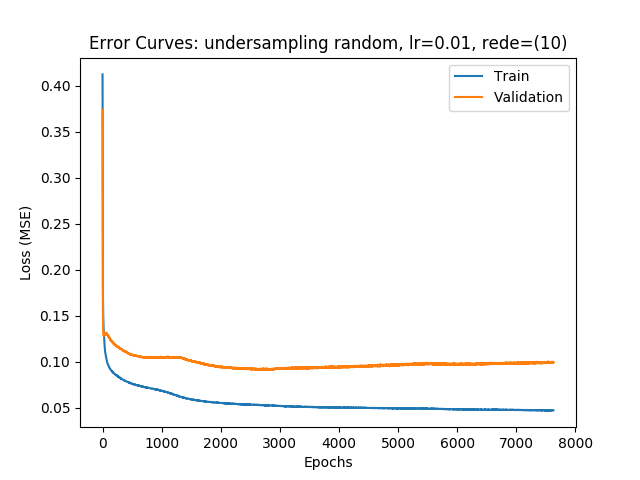

<IPython.core.display.Javascript object>


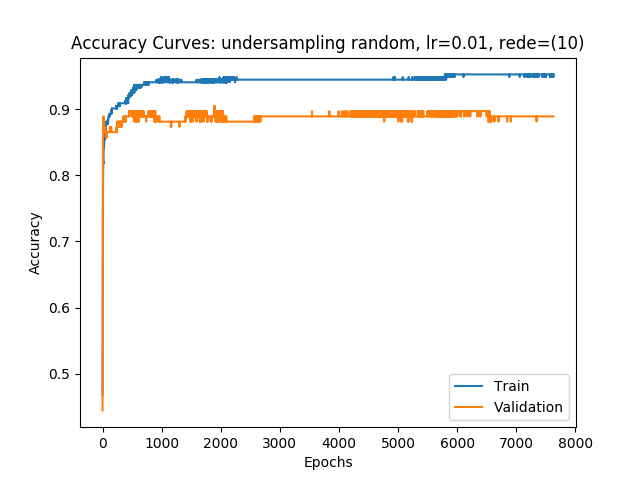

Matriz de confusão
[[1791  107]
 [   8   56]]

Train Loss:       0.0529
Validation Loss:  0.0912
Accuracy:         0.9414
MSE:              0.0586
AUROC:            0.9353


In [18]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [23]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20000)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.3786 - acc: 0.5635 - val_loss: 0.4562 - val_acc: 0.5635
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.3404 - acc: 0.5833 - val_loss: 0.4455 - val_acc: 0.5635
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3048 - acc: 0.6151 - val_loss: 0.4300 - val_acc: 0.5714
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.2765 - acc: 0.6548 - val_loss: 0.4157 - val_acc: 0.5952
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.2558 - acc: 0.6944 - val_loss: 0.4015 - val_acc: 0.6190
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.2344 - acc: 0.6984 - val_loss: 0.3797 - val_acc: 0.6667
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.2120 - acc: 0.7262 - val_loss: 0.3549 - val_acc: 0.6746
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9048 - val_loss: 0.1302 - val_acc: 0.8968
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1296 - val_acc: 0.8968
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1294 - val_acc: 0.8968
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1295 - val_acc: 0.8968
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1295 - val_acc: 0.8968
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1297 - val_acc: 0.8889
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1295 - val_acc: 0.8889
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1298 - v

252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9167 - val_loss: 0.1145 - val_acc: 0.8730
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9127 - val_loss: 0.1149 - val_acc: 0.8730
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9167 - val_loss: 0.1146 - val_acc: 0.8730
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9127 - val_loss: 0.1142 - val_acc: 0.8730
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9167 - val_loss: 0.1140 - val_acc: 0.8730
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9167 - val_loss: 0.1140 - val_acc: 0.8730
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9167 - val_loss: 0.1140 - val_acc: 0.8730
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9167 - val_loss: 0.1136 - v

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9246 - val_loss: 0.1058 - val_acc: 0.8651
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9246 - val_loss: 0.1054 - val_acc: 0.8651
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9246 - val_loss: 0.1056 - val_acc: 0.8651
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9246 - val_loss: 0.1055 - val_acc: 0.8651
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9246 - val_loss: 0.1059 - val_acc: 0.8651
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9246 - val_loss: 0.1055 - val_acc: 0.8651
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9246 - val_loss: 0.1059 - val_acc: 0.8651
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9246 - val_loss: 0.1053 - v

252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9325 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.1012 - val_acc: 0.8810
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.1012 - val_acc: 0.8810
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.1013 - val_acc: 0.8810
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.1008 - v

252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9405 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9405 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9405 - val_loss: 0.1000 - val_acc: 0.8651
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9405 - val_loss: 0.0996 - val_acc: 0.8651
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9405 - val_loss: 0.0998 - val_acc: 0.8651
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9405 - val_loss: 0.1002 - val_acc: 0.8651
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9405 - val_loss: 0.0998 - val_acc: 0.8651
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9405 - val_loss: 0.1000 - v

252/252 [==============================] - 0s - loss: 0.0531 - acc: 0.9444 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9444 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0531 - acc: 0.9405 - val_loss: 0.1011 - val_acc: 0.8730
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9405 - val_loss: 0.1014 - val_acc: 0.8651
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0531 - acc: 0.9405 - val_loss: 0.1021 - val_acc: 0.8651
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9444 - val_loss: 0.1014 - val_acc: 0.8730
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9405 - val_loss: 0.1015 - val_acc: 0.8730
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.0531 - acc: 0.9405 - val_loss: 0.1013 - v

252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9405 - val_loss: 0.1037 - val_acc: 0.8571
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9405 - val_loss: 0.1036 - val_acc: 0.8651
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9405 - val_loss: 0.1042 - val_acc: 0.8651
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9405 - val_loss: 0.1038 - val_acc: 0.8651
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9444 - val_loss: 0.1033 - val_acc: 0.8651
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9444 - val_loss: 0.1033 - val_acc: 0.8651
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0502 - acc: 0.9405 - val_loss: 0.1031 - val_acc: 0.8571
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9444 - val_loss: 0.1026 - v

252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9444 - val_loss: 0.1053 - val_acc: 0.8492
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9444 - val_loss: 0.1053 - val_acc: 0.8492
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9444 - val_loss: 0.1060 - val_acc: 0.8571
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9444 - val_loss: 0.1056 - val_acc: 0.8492
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9444 - val_loss: 0.1057 - val_acc: 0.8492
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9444 - val_loss: 0.1057 - val_acc: 0.8492
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0481 - acc: 0.9444 - val_loss: 0.1061 - val_acc: 0.8492
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.0479 - acc: 0.9444 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0464 - acc: 0.9444 - val_loss: 0.1094 - val_acc: 0.8571
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0466 - acc: 0.9444 - val_loss: 0.1097 - val_acc: 0.8571
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0464 - acc: 0.9444 - val_loss: 0.1091 - val_acc: 0.8571
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0465 - acc: 0.9484 - val_loss: 0.1099 - val_acc: 0.8571
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0466 - acc: 0.9444 - val_loss: 0.1095 - val_acc: 0.8571
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0465 - acc: 0.9484 - val_loss: 0.1092 - val_acc: 0.8571
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.0465 - acc: 0.9484 - val_loss: 0.1098 - val_acc: 0.8571
Epoch 1142/100000
252/252 [==============================] - 0s - loss: 0.0464 - acc: 0.9484 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0450 - acc: 0.9524 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 1261/100000
252/252 [==============================] - 0s - loss: 0.0449 - acc: 0.9524 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0449 - acc: 0.9524 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0450 - acc: 0.9484 - val_loss: 0.1135 - val_acc: 0.8571
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0448 - acc: 0.9524 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0449 - acc: 0.9524 - val_loss: 0.1124 - val_acc: 0.8571
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.0448 - acc: 0.9524 - val_loss: 0.1122 - val_acc: 0.8571
Epoch 1267/100000
252/252 [==============================] - 0s - loss: 0.0450 - acc: 0.9524 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0436 - acc: 0.9524 - val_loss: 0.1154 - val_acc: 0.8492
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0437 - acc: 0.9524 - val_loss: 0.1157 - val_acc: 0.8492
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0435 - acc: 0.9524 - val_loss: 0.1155 - val_acc: 0.8492
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0438 - acc: 0.9524 - val_loss: 0.1157 - val_acc: 0.8492
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0437 - acc: 0.9524 - val_loss: 0.1160 - val_acc: 0.8492
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0436 - acc: 0.9524 - val_loss: 0.1152 - val_acc: 0.8492
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.0438 - acc: 0.9524 - val_loss: 0.1156 - val_acc: 0.8492
Epoch 1393/100000
252/252 [==============================] - 0s - loss: 0.0437 - acc: 0.9524 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0424 - acc: 0.9563 - val_loss: 0.1178 - val_acc: 0.8492
Epoch 1512/100000
252/252 [==============================] - ETA: 0s - loss: 0.0228 - acc: 0.968 - 0s - loss: 0.0425 - acc: 0.9524 - val_loss: 0.1186 - val_acc: 0.8413
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0426 - acc: 0.9524 - val_loss: 0.1181 - val_acc: 0.8413
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0425 - acc: 0.9524 - val_loss: 0.1179 - val_acc: 0.8413
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0426 - acc: 0.9563 - val_loss: 0.1172 - val_acc: 0.8492
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0424 - acc: 0.9524 - val_loss: 0.1166 - val_acc: 0.8492
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.0426 - acc: 0.9563 - val_loss: 0.1180 - val_acc: 0.8413
Epoch 1518/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0415 - acc: 0.9563 - val_loss: 0.1197 - val_acc: 0.8413
Epoch 1637/100000
252/252 [==============================] - 0s - loss: 0.0415 - acc: 0.9563 - val_loss: 0.1204 - val_acc: 0.8413
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0413 - acc: 0.9563 - val_loss: 0.1208 - val_acc: 0.8413
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0417 - acc: 0.9563 - val_loss: 0.1198 - val_acc: 0.8413
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0414 - acc: 0.9563 - val_loss: 0.1194 - val_acc: 0.8413
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0415 - acc: 0.9563 - val_loss: 0.1195 - val_acc: 0.8413
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0414 - acc: 0.9563 - val_loss: 0.1200 - val_acc: 0.8413
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.0417 - acc: 0.9563 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0407 - acc: 0.9563 - val_loss: 0.1237 - val_acc: 0.8413
Epoch 1762/100000
252/252 [==============================] - 0s - loss: 0.0405 - acc: 0.9563 - val_loss: 0.1236 - val_acc: 0.8413
Epoch 1763/100000
252/252 [==============================] - 0s - loss: 0.0407 - acc: 0.9563 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0407 - acc: 0.9563 - val_loss: 0.1230 - val_acc: 0.8413
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0406 - acc: 0.9563 - val_loss: 0.1232 - val_acc: 0.8413
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0406 - acc: 0.9563 - val_loss: 0.1242 - val_acc: 0.8413
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0407 - acc: 0.9563 - val_loss: 0.1235 - val_acc: 0.8413
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0406 - acc: 0.9563 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0400 - acc: 0.9563 - val_loss: 0.1261 - val_acc: 0.8413
Epoch 1888/100000
252/252 [==============================] - 0s - loss: 0.0399 - acc: 0.9563 - val_loss: 0.1256 - val_acc: 0.8413
Epoch 1889/100000
252/252 [==============================] - 0s - loss: 0.0396 - acc: 0.9563 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0398 - acc: 0.9563 - val_loss: 0.1256 - val_acc: 0.8413
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0397 - acc: 0.9563 - val_loss: 0.1268 - val_acc: 0.8413
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0399 - acc: 0.9563 - val_loss: 0.1263 - val_acc: 0.8413
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.0398 - acc: 0.9563 - val_loss: 0.1263 - val_acc: 0.8413
Epoch 1894/100000
252/252 [==============================] - 0s - loss: 0.0400 - acc: 0.9563 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0392 - acc: 0.9563 - val_loss: 0.1288 - val_acc: 0.8492
Epoch 2014/100000
252/252 [==============================] - 0s - loss: 0.0390 - acc: 0.9603 - val_loss: 0.1293 - val_acc: 0.8413
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0393 - acc: 0.9563 - val_loss: 0.1289 - val_acc: 0.8413
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0393 - acc: 0.9563 - val_loss: 0.1287 - val_acc: 0.8492
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0392 - acc: 0.9603 - val_loss: 0.1285 - val_acc: 0.8492
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0390 - acc: 0.9563 - val_loss: 0.1288 - val_acc: 0.8492
Epoch 2019/100000
252/252 [==============================] - 0s - loss: 0.0393 - acc: 0.9563 - val_loss: 0.1282 - val_acc: 0.8492
Epoch 2020/100000
252/252 [==============================] - 0s - loss: 0.0390 - acc: 0.9603 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0387 - acc: 0.9603 - val_loss: 0.1286 - val_acc: 0.8413
Epoch 2139/100000
252/252 [==============================] - 0s - loss: 0.0388 - acc: 0.9563 - val_loss: 0.1300 - val_acc: 0.8492
Epoch 2140/100000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9603 - val_loss: 0.1300 - val_acc: 0.8492
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9603 - val_loss: 0.1301 - val_acc: 0.8492
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9563 - val_loss: 0.1300 - val_acc: 0.8492
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0386 - acc: 0.9603 - val_loss: 0.1307 - val_acc: 0.8492
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0386 - acc: 0.9603 - val_loss: 0.1301 - val_acc: 0.8492
Epoch 2145/100000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9563 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0382 - acc: 0.9603 - val_loss: 0.1303 - val_acc: 0.8492
Epoch 2265/100000
252/252 [==============================] - 0s - loss: 0.0382 - acc: 0.9603 - val_loss: 0.1304 - val_acc: 0.8413
Epoch 2266/100000
252/252 [==============================] - 0s - loss: 0.0381 - acc: 0.9563 - val_loss: 0.1320 - val_acc: 0.8492
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0380 - acc: 0.9603 - val_loss: 0.1316 - val_acc: 0.8492
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0381 - acc: 0.9603 - val_loss: 0.1315 - val_acc: 0.8492
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0380 - acc: 0.9603 - val_loss: 0.1331 - val_acc: 0.8492
Epoch 2270/100000
252/252 [==============================] - 0s - loss: 0.0379 - acc: 0.9643 - val_loss: 0.1318 - val_acc: 0.8492
Epoch 2271/100000
252/252 [==============================] - 0s - loss: 0.0380 - acc: 0.9603 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0378 - acc: 0.9603 - val_loss: 0.1346 - val_acc: 0.8413
Epoch 2389/100000
252/252 [==============================] - 0s - loss: 0.0376 - acc: 0.9603 - val_loss: 0.1328 - val_acc: 0.8492
Epoch 2390/100000
252/252 [==============================] - 0s - loss: 0.0375 - acc: 0.9643 - val_loss: 0.1323 - val_acc: 0.8492
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0376 - acc: 0.9603 - val_loss: 0.1319 - val_acc: 0.8492
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0374 - acc: 0.9603 - val_loss: 0.1319 - val_acc: 0.8492
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0376 - acc: 0.9603 - val_loss: 0.1320 - val_acc: 0.8492
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0375 - acc: 0.9603 - val_loss: 0.1308 - val_acc: 0.8492
Epoch 2395/100000
252/252 [==============================] - 0s - loss: 0.0377 - acc: 0.9603 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0372 - acc: 0.9643 - val_loss: 0.1340 - val_acc: 0.8492
Epoch 2514/100000
252/252 [==============================] - 0s - loss: 0.0375 - acc: 0.9603 - val_loss: 0.1341 - val_acc: 0.8492
Epoch 2515/100000
252/252 [==============================] - 0s - loss: 0.0372 - acc: 0.9603 - val_loss: 0.1351 - val_acc: 0.8413
Epoch 2516/100000
252/252 [==============================] - 0s - loss: 0.0371 - acc: 0.9603 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0370 - acc: 0.9643 - val_loss: 0.1347 - val_acc: 0.8413
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0372 - acc: 0.9603 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2519/100000
252/252 [==============================] - 0s - loss: 0.0372 - acc: 0.9603 - val_loss: 0.1339 - val_acc: 0.8492
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0373 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0369 - acc: 0.9603 - val_loss: 0.1361 - val_acc: 0.8333
Epoch 2639/100000
252/252 [==============================] - 0s - loss: 0.0369 - acc: 0.9603 - val_loss: 0.1354 - val_acc: 0.8333
Epoch 2640/100000
252/252 [==============================] - 0s - loss: 0.0368 - acc: 0.9603 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2641/100000
252/252 [==============================] - 0s - loss: 0.0368 - acc: 0.9643 - val_loss: 0.1358 - val_acc: 0.8333
Epoch 2642/100000
252/252 [==============================] - 0s - loss: 0.0367 - acc: 0.9603 - val_loss: 0.1353 - val_acc: 0.8333
Epoch 2643/100000
252/252 [==============================] - 0s - loss: 0.0366 - acc: 0.9643 - val_loss: 0.1337 - val_acc: 0.8413
Epoch 2644/100000
252/252 [==============================] - 0s - loss: 0.0367 - acc: 0.9643 - val_loss: 0.1334 - val_acc: 0.8413
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0369 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0363 - acc: 0.9643 - val_loss: 0.1350 - val_acc: 0.8413
Epoch 2763/100000
252/252 [==============================] - 0s - loss: 0.0365 - acc: 0.9603 - val_loss: 0.1358 - val_acc: 0.8333
Epoch 2764/100000
252/252 [==============================] - 0s - loss: 0.0362 - acc: 0.9603 - val_loss: 0.1371 - val_acc: 0.8333
Epoch 2765/100000
252/252 [==============================] - 0s - loss: 0.0365 - acc: 0.9603 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2766/100000
252/252 [==============================] - 0s - loss: 0.0363 - acc: 0.9603 - val_loss: 0.1364 - val_acc: 0.8333
Epoch 2767/100000
252/252 [==============================] - 0s - loss: 0.0362 - acc: 0.9643 - val_loss: 0.1368 - val_acc: 0.8333
Epoch 2768/100000
252/252 [==============================] - 0s - loss: 0.0363 - acc: 0.9643 - val_loss: 0.1361 - val_acc: 0.8333
Epoch 2769/100000
252/252 [==============================] - ETA: 0s - loss: 0.0269 - acc: 0.968 - 0s - loss

252/252 [==============================] - 0s - loss: 0.0362 - acc: 0.9603 - val_loss: 0.1368 - val_acc: 0.8333
Epoch 2888/100000
252/252 [==============================] - 0s - loss: 0.0362 - acc: 0.9643 - val_loss: 0.1378 - val_acc: 0.8333
Epoch 2889/100000
252/252 [==============================] - 0s - loss: 0.0360 - acc: 0.9603 - val_loss: 0.1376 - val_acc: 0.8333
Epoch 2890/100000
252/252 [==============================] - 0s - loss: 0.0359 - acc: 0.9643 - val_loss: 0.1363 - val_acc: 0.8333
Epoch 2891/100000
252/252 [==============================] - 0s - loss: 0.0360 - acc: 0.9643 - val_loss: 0.1366 - val_acc: 0.8333
Epoch 2892/100000
252/252 [==============================] - 0s - loss: 0.0358 - acc: 0.9643 - val_loss: 0.1375 - val_acc: 0.8333
Epoch 2893/100000
252/252 [==============================] - 0s - loss: 0.0360 - acc: 0.9603 - val_loss: 0.1377 - val_acc: 0.8333
Epoch 2894/100000
252/252 [==============================] - 0s - loss: 0.0358 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0357 - acc: 0.9643 - val_loss: 0.1371 - val_acc: 0.8333
Epoch 3014/100000
252/252 [==============================] - 0s - loss: 0.0357 - acc: 0.9643 - val_loss: 0.1376 - val_acc: 0.8333
Epoch 3015/100000
252/252 [==============================] - 0s - loss: 0.0357 - acc: 0.9603 - val_loss: 0.1377 - val_acc: 0.8333
Epoch 3016/100000
252/252 [==============================] - 0s - loss: 0.0355 - acc: 0.9603 - val_loss: 0.1372 - val_acc: 0.8333
Epoch 3017/100000
252/252 [==============================] - 0s - loss: 0.0358 - acc: 0.9643 - val_loss: 0.1371 - val_acc: 0.8333
Epoch 3018/100000
252/252 [==============================] - 0s - loss: 0.0356 - acc: 0.9603 - val_loss: 0.1370 - val_acc: 0.8333
Epoch 3019/100000
252/252 [==============================] - 0s - loss: 0.0357 - acc: 0.9603 - val_loss: 0.1379 - val_acc: 0.8333
Epoch 3020/100000
252/252 [==============================] - 0s - loss: 0.0356 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9643 - val_loss: 0.1375 - val_acc: 0.8333
Epoch 3139/100000
252/252 [==============================] - 0s - loss: 0.0355 - acc: 0.9643 - val_loss: 0.1380 - val_acc: 0.8333
Epoch 3140/100000
252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9603 - val_loss: 0.1377 - val_acc: 0.8333
Epoch 3141/100000
252/252 [==============================] - 0s - loss: 0.0353 - acc: 0.9643 - val_loss: 0.1375 - val_acc: 0.8333
Epoch 3142/100000
252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9643 - val_loss: 0.1385 - val_acc: 0.8333
Epoch 3143/100000
252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9643 - val_loss: 0.1388 - val_acc: 0.8333
Epoch 3144/100000
252/252 [==============================] - 0s - loss: 0.0352 - acc: 0.9643 - val_loss: 0.1388 - val_acc: 0.8333
Epoch 3145/100000
252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9603 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0351 - acc: 0.9643 - val_loss: 0.1384 - val_acc: 0.8333
Epoch 3265/100000
252/252 [==============================] - 0s - loss: 0.0350 - acc: 0.9643 - val_loss: 0.1379 - val_acc: 0.8333
Epoch 3266/100000
252/252 [==============================] - 0s - loss: 0.0350 - acc: 0.9643 - val_loss: 0.1388 - val_acc: 0.8333
Epoch 3267/100000
252/252 [==============================] - 0s - loss: 0.0349 - acc: 0.9643 - val_loss: 0.1379 - val_acc: 0.8333
Epoch 3268/100000
252/252 [==============================] - 0s - loss: 0.0350 - acc: 0.9643 - val_loss: 0.1402 - val_acc: 0.8333
Epoch 3269/100000
252/252 [==============================] - 0s - loss: 0.0351 - acc: 0.9643 - val_loss: 0.1402 - val_acc: 0.8333
Epoch 3270/100000
252/252 [==============================] - 0s - loss: 0.0349 - acc: 0.9643 - val_loss: 0.1387 - val_acc: 0.8333
Epoch 3271/100000
252/252 [==============================] - 0s - loss: 0.0350 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0345 - acc: 0.9643 - val_loss: 0.1399 - val_acc: 0.8333
Epoch 3389/100000
252/252 [==============================] - 0s - loss: 0.0346 - acc: 0.9643 - val_loss: 0.1387 - val_acc: 0.8333
Epoch 3390/100000
252/252 [==============================] - 0s - loss: 0.0347 - acc: 0.9643 - val_loss: 0.1408 - val_acc: 0.8333
Epoch 3391/100000
252/252 [==============================] - 0s - loss: 0.0347 - acc: 0.9643 - val_loss: 0.1403 - val_acc: 0.8333
Epoch 3392/100000
252/252 [==============================] - 0s - loss: 0.0346 - acc: 0.9643 - val_loss: 0.1397 - val_acc: 0.8333
Epoch 3393/100000
252/252 [==============================] - 0s - loss: 0.0344 - acc: 0.9643 - val_loss: 0.1403 - val_acc: 0.8333
Epoch 3394/100000
252/252 [==============================] - 0s - loss: 0.0346 - acc: 0.9643 - val_loss: 0.1403 - val_acc: 0.8333
Epoch 3395/100000
252/252 [==============================] - 0s - loss: 0.0348 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0343 - acc: 0.9643 - val_loss: 0.1405 - val_acc: 0.8333
Epoch 3514/100000
252/252 [==============================] - 0s - loss: 0.0342 - acc: 0.9643 - val_loss: 0.1403 - val_acc: 0.8333
Epoch 3515/100000
252/252 [==============================] - 0s - loss: 0.0341 - acc: 0.9643 - val_loss: 0.1415 - val_acc: 0.8333
Epoch 3516/100000
252/252 [==============================] - 0s - loss: 0.0345 - acc: 0.9643 - val_loss: 0.1427 - val_acc: 0.8333
Epoch 3517/100000
252/252 [==============================] - 0s - loss: 0.0342 - acc: 0.9643 - val_loss: 0.1410 - val_acc: 0.8333
Epoch 3518/100000
252/252 [==============================] - 0s - loss: 0.0343 - acc: 0.9643 - val_loss: 0.1406 - val_acc: 0.8333
Epoch 3519/100000
252/252 [==============================] - 0s - loss: 0.0344 - acc: 0.9643 - val_loss: 0.1415 - val_acc: 0.8333
Epoch 3520/100000
252/252 [==============================] - 0s - loss: 0.0342 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0340 - acc: 0.9643 - val_loss: 0.1413 - val_acc: 0.8333
Epoch 3639/100000
252/252 [==============================] - 0s - loss: 0.0340 - acc: 0.9643 - val_loss: 0.1419 - val_acc: 0.8333
Epoch 3640/100000
252/252 [==============================] - 0s - loss: 0.0343 - acc: 0.9643 - val_loss: 0.1419 - val_acc: 0.8333
Epoch 3641/100000
252/252 [==============================] - 0s - loss: 0.0341 - acc: 0.9643 - val_loss: 0.1403 - val_acc: 0.8333
Epoch 3642/100000
252/252 [==============================] - 0s - loss: 0.0340 - acc: 0.9643 - val_loss: 0.1398 - val_acc: 0.8333
Epoch 3643/100000
252/252 [==============================] - 0s - loss: 0.0339 - acc: 0.9643 - val_loss: 0.1416 - val_acc: 0.8333
Epoch 3644/100000
252/252 [==============================] - 0s - loss: 0.0342 - acc: 0.9643 - val_loss: 0.1414 - val_acc: 0.8333
Epoch 3645/100000
252/252 [==============================] - 0s - loss: 0.0340 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0339 - acc: 0.9643 - val_loss: 0.1434 - val_acc: 0.8333
Epoch 3765/100000
252/252 [==============================] - 0s - loss: 0.0337 - acc: 0.9643 - val_loss: 0.1420 - val_acc: 0.8333
Epoch 3766/100000
252/252 [==============================] - 0s - loss: 0.0337 - acc: 0.9643 - val_loss: 0.1446 - val_acc: 0.8333
Epoch 3767/100000
252/252 [==============================] - 0s - loss: 0.0336 - acc: 0.9643 - val_loss: 0.1433 - val_acc: 0.8333
Epoch 3768/100000
252/252 [==============================] - 0s - loss: 0.0335 - acc: 0.9643 - val_loss: 0.1436 - val_acc: 0.8333
Epoch 3769/100000
252/252 [==============================] - 0s - loss: 0.0336 - acc: 0.9643 - val_loss: 0.1430 - val_acc: 0.8333
Epoch 3770/100000
252/252 [==============================] - 0s - loss: 0.0337 - acc: 0.9643 - val_loss: 0.1416 - val_acc: 0.8333
Epoch 3771/100000
252/252 [==============================] - 0s - loss: 0.0336 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0332 - acc: 0.9643 - val_loss: 0.1446 - val_acc: 0.8333
Epoch 3890/100000
252/252 [==============================] - 0s - loss: 0.0335 - acc: 0.9643 - val_loss: 0.1452 - val_acc: 0.8333
Epoch 3891/100000
252/252 [==============================] - 0s - loss: 0.0331 - acc: 0.9643 - val_loss: 0.1443 - val_acc: 0.8333
Epoch 3892/100000
252/252 [==============================] - 0s - loss: 0.0333 - acc: 0.9643 - val_loss: 0.1422 - val_acc: 0.8333
Epoch 3893/100000
252/252 [==============================] - 0s - loss: 0.0333 - acc: 0.9643 - val_loss: 0.1425 - val_acc: 0.8333
Epoch 3894/100000
252/252 [==============================] - 0s - loss: 0.0333 - acc: 0.9643 - val_loss: 0.1427 - val_acc: 0.8333
Epoch 3895/100000
252/252 [==============================] - 0s - loss: 0.0331 - acc: 0.9643 - val_loss: 0.1420 - val_acc: 0.8333
Epoch 3896/100000
252/252 [==============================] - 0s - loss: 0.0334 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0332 - acc: 0.9643 - val_loss: 0.1427 - val_acc: 0.8333
Epoch 4015/100000
252/252 [==============================] - 0s - loss: 0.0330 - acc: 0.9643 - val_loss: 0.1426 - val_acc: 0.8333
Epoch 4016/100000
252/252 [==============================] - 0s - loss: 0.0330 - acc: 0.9643 - val_loss: 0.1415 - val_acc: 0.8333
Epoch 4017/100000
252/252 [==============================] - 0s - loss: 0.0331 - acc: 0.9643 - val_loss: 0.1412 - val_acc: 0.8333
Epoch 4018/100000
252/252 [==============================] - 0s - loss: 0.0331 - acc: 0.9643 - val_loss: 0.1409 - val_acc: 0.8333
Epoch 4019/100000
252/252 [==============================] - 0s - loss: 0.0332 - acc: 0.9643 - val_loss: 0.1442 - val_acc: 0.8333
Epoch 4020/100000
252/252 [==============================] - 0s - loss: 0.0331 - acc: 0.9643 - val_loss: 0.1446 - val_acc: 0.8333
Epoch 4021/100000
252/252 [==============================] - 0s - loss: 0.0333 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0327 - acc: 0.9643 - val_loss: 0.1437 - val_acc: 0.8333
Epoch 4141/100000
252/252 [==============================] - 0s - loss: 0.0328 - acc: 0.9643 - val_loss: 0.1451 - val_acc: 0.8333
Epoch 4142/100000
252/252 [==============================] - 0s - loss: 0.0327 - acc: 0.9643 - val_loss: 0.1442 - val_acc: 0.8333
Epoch 4143/100000
252/252 [==============================] - 0s - loss: 0.0328 - acc: 0.9643 - val_loss: 0.1433 - val_acc: 0.8333
Epoch 4144/100000
252/252 [==============================] - 0s - loss: 0.0329 - acc: 0.9643 - val_loss: 0.1438 - val_acc: 0.8333
Epoch 4145/100000
252/252 [==============================] - 0s - loss: 0.0328 - acc: 0.9643 - val_loss: 0.1440 - val_acc: 0.8333
Epoch 4146/100000
252/252 [==============================] - 0s - loss: 0.0327 - acc: 0.9643 - val_loss: 0.1428 - val_acc: 0.8333
Epoch 4147/100000
252/252 [==============================] - 0s - loss: 0.0327 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0323 - acc: 0.9643 - val_loss: 0.1446 - val_acc: 0.8254
Epoch 4267/100000
252/252 [==============================] - 0s - loss: 0.0324 - acc: 0.9643 - val_loss: 0.1458 - val_acc: 0.8333
Epoch 4268/100000
252/252 [==============================] - 0s - loss: 0.0326 - acc: 0.9643 - val_loss: 0.1472 - val_acc: 0.8333
Epoch 4269/100000
252/252 [==============================] - 0s - loss: 0.0325 - acc: 0.9643 - val_loss: 0.1475 - val_acc: 0.8333
Epoch 4270/100000
252/252 [==============================] - 0s - loss: 0.0328 - acc: 0.9643 - val_loss: 0.1456 - val_acc: 0.8333
Epoch 4271/100000
252/252 [==============================] - 0s - loss: 0.0326 - acc: 0.9643 - val_loss: 0.1448 - val_acc: 0.8254
Epoch 4272/100000
252/252 [==============================] - 0s - loss: 0.0325 - acc: 0.9643 - val_loss: 0.1473 - val_acc: 0.8333
Epoch 4273/100000
252/252 [==============================] - 0s - loss: 0.0326 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0325 - acc: 0.9643 - val_loss: 0.1464 - val_acc: 0.8333
Epoch 4392/100000
252/252 [==============================] - 0s - loss: 0.0322 - acc: 0.9643 - val_loss: 0.1464 - val_acc: 0.8333
Epoch 4393/100000
252/252 [==============================] - 0s - loss: 0.0324 - acc: 0.9643 - val_loss: 0.1471 - val_acc: 0.8333
Epoch 4394/100000
252/252 [==============================] - 0s - loss: 0.0324 - acc: 0.9643 - val_loss: 0.1479 - val_acc: 0.8333
Epoch 4395/100000
252/252 [==============================] - 0s - loss: 0.0323 - acc: 0.9643 - val_loss: 0.1466 - val_acc: 0.8254
Epoch 4396/100000
252/252 [==============================] - 0s - loss: 0.0323 - acc: 0.9643 - val_loss: 0.1443 - val_acc: 0.8254
Epoch 4397/100000
252/252 [==============================] - 0s - loss: 0.0324 - acc: 0.9643 - val_loss: 0.1445 - val_acc: 0.8333
Epoch 4398/100000
252/252 [==============================] - 0s - loss: 0.0323 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0320 - acc: 0.9643 - val_loss: 0.1445 - val_acc: 0.8175
Epoch 4518/100000
252/252 [==============================] - 0s - loss: 0.0320 - acc: 0.9643 - val_loss: 0.1447 - val_acc: 0.8254
Epoch 4519/100000
252/252 [==============================] - 0s - loss: 0.0321 - acc: 0.9643 - val_loss: 0.1451 - val_acc: 0.8333
Epoch 4520/100000
252/252 [==============================] - 0s - loss: 0.0321 - acc: 0.9643 - val_loss: 0.1470 - val_acc: 0.8333
Epoch 4521/100000
252/252 [==============================] - 0s - loss: 0.0321 - acc: 0.9643 - val_loss: 0.1459 - val_acc: 0.8333
Epoch 4522/100000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9643 - val_loss: 0.1443 - val_acc: 0.8254
Epoch 4523/100000
252/252 [==============================] - 0s - loss: 0.0322 - acc: 0.9643 - val_loss: 0.1466 - val_acc: 0.8333
Epoch 4524/100000
252/252 [==============================] - 0s - loss: 0.0321 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0319 - acc: 0.9643 - val_loss: 0.1451 - val_acc: 0.8175
Epoch 4642/100000
252/252 [==============================] - 0s - loss: 0.0319 - acc: 0.9643 - val_loss: 0.1468 - val_acc: 0.8175
Epoch 4643/100000
252/252 [==============================] - 0s - loss: 0.0319 - acc: 0.9643 - val_loss: 0.1478 - val_acc: 0.8333
Epoch 4644/100000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9643 - val_loss: 0.1483 - val_acc: 0.8333
Epoch 4645/100000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9643 - val_loss: 0.1477 - val_acc: 0.8254
Epoch 4646/100000
252/252 [==============================] - 0s - loss: 0.0319 - acc: 0.9643 - val_loss: 0.1488 - val_acc: 0.8333
Epoch 4647/100000
252/252 [==============================] - 0s - loss: 0.0317 - acc: 0.9643 - val_loss: 0.1455 - val_acc: 0.8175
Epoch 4648/100000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0317 - acc: 0.9643 - val_loss: 0.1472 - val_acc: 0.8254
Epoch 4768/100000
252/252 [==============================] - 0s - loss: 0.0316 - acc: 0.9643 - val_loss: 0.1464 - val_acc: 0.8175
Epoch 4769/100000
252/252 [==============================] - 0s - loss: 0.0316 - acc: 0.9643 - val_loss: 0.1497 - val_acc: 0.8333
Epoch 4770/100000
252/252 [==============================] - 0s - loss: 0.0316 - acc: 0.9643 - val_loss: 0.1477 - val_acc: 0.8333
Epoch 4771/100000
252/252 [==============================] - 0s - loss: 0.0317 - acc: 0.9643 - val_loss: 0.1446 - val_acc: 0.8175
Epoch 4772/100000
252/252 [==============================] - 0s - loss: 0.0316 - acc: 0.9643 - val_loss: 0.1449 - val_acc: 0.8175
Epoch 4773/100000
252/252 [==============================] - 0s - loss: 0.0317 - acc: 0.9643 - val_loss: 0.1440 - val_acc: 0.8175
Epoch 4774/100000
252/252 [==============================] - 0s - loss: 0.0317 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0314 - acc: 0.9643 - val_loss: 0.1456 - val_acc: 0.8175
Epoch 4893/100000
252/252 [==============================] - 0s - loss: 0.0315 - acc: 0.9643 - val_loss: 0.1476 - val_acc: 0.8175
Epoch 4894/100000
252/252 [==============================] - 0s - loss: 0.0315 - acc: 0.9643 - val_loss: 0.1499 - val_acc: 0.8175
Epoch 4895/100000
252/252 [==============================] - 0s - loss: 0.0313 - acc: 0.9643 - val_loss: 0.1486 - val_acc: 0.8175
Epoch 4896/100000
252/252 [==============================] - 0s - loss: 0.0314 - acc: 0.9643 - val_loss: 0.1475 - val_acc: 0.8175
Epoch 4897/100000
252/252 [==============================] - 0s - loss: 0.0316 - acc: 0.9643 - val_loss: 0.1454 - val_acc: 0.8175
Epoch 4898/100000
252/252 [==============================] - 0s - loss: 0.0314 - acc: 0.9643 - val_loss: 0.1453 - val_acc: 0.8175
Epoch 4899/100000
252/252 [==============================] - 0s - loss: 0.0312 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0310 - acc: 0.9643 - val_loss: 0.1482 - val_acc: 0.8175
Epoch 5018/100000
252/252 [==============================] - 0s - loss: 0.0314 - acc: 0.9643 - val_loss: 0.1481 - val_acc: 0.8175
Epoch 5019/100000
252/252 [==============================] - 0s - loss: 0.0311 - acc: 0.9643 - val_loss: 0.1461 - val_acc: 0.8175
Epoch 5020/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1479 - val_acc: 0.8175
Epoch 5021/100000
252/252 [==============================] - 0s - loss: 0.0310 - acc: 0.9643 - val_loss: 0.1464 - val_acc: 0.8175
Epoch 5022/100000
252/252 [==============================] - 0s - loss: 0.0311 - acc: 0.9643 - val_loss: 0.1449 - val_acc: 0.8175
Epoch 5023/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1466 - val_acc: 0.8175
Epoch 5024/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1464 - val_acc: 0.8175
Epoch 5144/100000
252/252 [==============================] - 0s - loss: 0.0308 - acc: 0.9643 - val_loss: 0.1467 - val_acc: 0.8175
Epoch 5145/100000
252/252 [==============================] - 0s - loss: 0.0308 - acc: 0.9643 - val_loss: 0.1478 - val_acc: 0.8175
Epoch 5146/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1452 - val_acc: 0.8175
Epoch 5147/100000
252/252 [==============================] - 0s - loss: 0.0307 - acc: 0.9643 - val_loss: 0.1458 - val_acc: 0.8175
Epoch 5148/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1449 - val_acc: 0.8175
Epoch 5149/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1454 - val_acc: 0.8175
Epoch 5150/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0304 - acc: 0.9643 - val_loss: 0.1471 - val_acc: 0.8254
Epoch 5270/100000
252/252 [==============================] - 0s - loss: 0.0307 - acc: 0.9643 - val_loss: 0.1484 - val_acc: 0.8175
Epoch 5271/100000
252/252 [==============================] - 0s - loss: 0.0306 - acc: 0.9643 - val_loss: 0.1457 - val_acc: 0.8175
Epoch 5272/100000
252/252 [==============================] - 0s - loss: 0.0309 - acc: 0.9643 - val_loss: 0.1454 - val_acc: 0.8175
Epoch 5273/100000
252/252 [==============================] - 0s - loss: 0.0305 - acc: 0.9643 - val_loss: 0.1475 - val_acc: 0.8175
Epoch 5274/100000
252/252 [==============================] - 0s - loss: 0.0306 - acc: 0.9643 - val_loss: 0.1483 - val_acc: 0.8175
Epoch 5275/100000
252/252 [==============================] - 0s - loss: 0.0308 - acc: 0.9643 - val_loss: 0.1470 - val_acc: 0.8175
Epoch 5276/100000
252/252 [==============================] - 0s - loss: 0.0305 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0302 - acc: 0.9643 - val_loss: 0.1507 - val_acc: 0.8175
Epoch 5395/100000
252/252 [==============================] - 0s - loss: 0.0305 - acc: 0.9643 - val_loss: 0.1494 - val_acc: 0.8175
Epoch 5396/100000
252/252 [==============================] - 0s - loss: 0.0305 - acc: 0.9643 - val_loss: 0.1478 - val_acc: 0.8175
Epoch 5397/100000
252/252 [==============================] - 0s - loss: 0.0301 - acc: 0.9643 - val_loss: 0.1478 - val_acc: 0.8254
Epoch 5398/100000
252/252 [==============================] - ETA: 0s - loss: 0.0400 - acc: 0.906 - 0s - loss: 0.0300 - acc: 0.9643 - val_loss: 0.1479 - val_acc: 0.8175
Epoch 5399/100000
252/252 [==============================] - 0s - loss: 0.0304 - acc: 0.9643 - val_loss: 0.1457 - val_acc: 0.8175
Epoch 5400/100000
252/252 [==============================] - 0s - loss: 0.0305 - acc: 0.9643 - val_loss: 0.1468 - val_acc: 0.8333
Epoch 5401/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0300 - acc: 0.9643 - val_loss: 0.1505 - val_acc: 0.8254
Epoch 5520/100000
252/252 [==============================] - 0s - loss: 0.0302 - acc: 0.9643 - val_loss: 0.1490 - val_acc: 0.8333
Epoch 5521/100000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9643 - val_loss: 0.1484 - val_acc: 0.8333
Epoch 5522/100000
252/252 [==============================] - 0s - loss: 0.0302 - acc: 0.9643 - val_loss: 0.1496 - val_acc: 0.8254
Epoch 5523/100000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9643 - val_loss: 0.1476 - val_acc: 0.8254
Epoch 5524/100000
252/252 [==============================] - 0s - loss: 0.0302 - acc: 0.9643 - val_loss: 0.1481 - val_acc: 0.8333
Epoch 5525/100000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9643 - val_loss: 0.1480 - val_acc: 0.8333
Epoch 5526/100000
252/252 [==============================] - 0s - loss: 0.0301 - acc: 0.9643 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9643 - val_loss: 0.1493 - val_acc: 0.8333
Epoch 5646/100000
252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9643 - val_loss: 0.1498 - val_acc: 0.8333
Epoch 5647/100000
252/252 [==============================] - 0s - loss: 0.0297 - acc: 0.9643 - val_loss: 0.1498 - val_acc: 0.8333
Epoch 5648/100000
252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9683 - val_loss: 0.1477 - val_acc: 0.8254
Epoch 5649/100000
252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9643 - val_loss: 0.1490 - val_acc: 0.8333
Epoch 5650/100000
252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9643 - val_loss: 0.1490 - val_acc: 0.8333
Epoch 5651/100000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9643 - val_loss: 0.1501 - val_acc: 0.8254
Epoch 5652/100000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9683 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0296 - acc: 0.9722 - val_loss: 0.1461 - val_acc: 0.8254
Epoch 5771/100000
252/252 [==============================] - 0s - loss: 0.0295 - acc: 0.9683 - val_loss: 0.1456 - val_acc: 0.8254
Epoch 5772/100000
252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9683 - val_loss: 0.1473 - val_acc: 0.8333
Epoch 5773/100000
252/252 [==============================] - 0s - loss: 0.0296 - acc: 0.9643 - val_loss: 0.1478 - val_acc: 0.8254
Epoch 5774/100000
252/252 [==============================] - 0s - loss: 0.0295 - acc: 0.9683 - val_loss: 0.1489 - val_acc: 0.8333
Epoch 5775/100000
252/252 [==============================] - 0s - loss: 0.0297 - acc: 0.9643 - val_loss: 0.1505 - val_acc: 0.8333
Epoch 5776/100000
252/252 [==============================] - 0s - loss: 0.0295 - acc: 0.9643 - val_loss: 0.1491 - val_acc: 0.8254
Epoch 5777/100000
252/252 [==============================] - 0s - loss: 0.0294 - acc: 0.9683 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0294 - acc: 0.9722 - val_loss: 0.1520 - val_acc: 0.8254
Epoch 5896/100000
252/252 [==============================] - 0s - loss: 0.0293 - acc: 0.9683 - val_loss: 0.1489 - val_acc: 0.8254
Epoch 5897/100000
252/252 [==============================] - 0s - loss: 0.0295 - acc: 0.9722 - val_loss: 0.1507 - val_acc: 0.8254
Epoch 5898/100000
252/252 [==============================] - 0s - loss: 0.0297 - acc: 0.9643 - val_loss: 0.1484 - val_acc: 0.8254
Epoch 5899/100000
252/252 [==============================] - 0s - loss: 0.0294 - acc: 0.9722 - val_loss: 0.1478 - val_acc: 0.8254
Epoch 5900/100000
252/252 [==============================] - 0s - loss: 0.0294 - acc: 0.9722 - val_loss: 0.1476 - val_acc: 0.8254
Epoch 5901/100000
252/252 [==============================] - 0s - loss: 0.0295 - acc: 0.9683 - val_loss: 0.1469 - val_acc: 0.8254
Epoch 5902/100000
252/252 [==============================] - 0s - loss: 0.0293 - acc: 0.9722 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0290 - acc: 0.9722 - val_loss: 0.1484 - val_acc: 0.8254
Epoch 6022/100000
252/252 [==============================] - 0s - loss: 0.0291 - acc: 0.9722 - val_loss: 0.1475 - val_acc: 0.8254
Epoch 6023/100000
252/252 [==============================] - 0s - loss: 0.0293 - acc: 0.9722 - val_loss: 0.1491 - val_acc: 0.8254
Epoch 6024/100000
252/252 [==============================] - 0s - loss: 0.0291 - acc: 0.9762 - val_loss: 0.1502 - val_acc: 0.8254
Epoch 6025/100000
252/252 [==============================] - 0s - loss: 0.0292 - acc: 0.9762 - val_loss: 0.1502 - val_acc: 0.8254
Epoch 6026/100000
252/252 [==============================] - 0s - loss: 0.0292 - acc: 0.9762 - val_loss: 0.1500 - val_acc: 0.8254
Epoch 6027/100000
252/252 [==============================] - 0s - loss: 0.0293 - acc: 0.9683 - val_loss: 0.1503 - val_acc: 0.8254
Epoch 6028/100000
252/252 [==============================] - 0s - loss: 0.0291 - acc: 0.9722 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0289 - acc: 0.9762 - val_loss: 0.1475 - val_acc: 0.8254
Epoch 6147/100000
252/252 [==============================] - 0s - loss: 0.0290 - acc: 0.9762 - val_loss: 0.1502 - val_acc: 0.8254
Epoch 6148/100000
252/252 [==============================] - 0s - loss: 0.0289 - acc: 0.9762 - val_loss: 0.1482 - val_acc: 0.8254
Epoch 6149/100000
252/252 [==============================] - 0s - loss: 0.0288 - acc: 0.9722 - val_loss: 0.1495 - val_acc: 0.8254
Epoch 6150/100000
252/252 [==============================] - 0s - loss: 0.0290 - acc: 0.9762 - val_loss: 0.1501 - val_acc: 0.8254
Epoch 6151/100000
252/252 [==============================] - 0s - loss: 0.0289 - acc: 0.9762 - val_loss: 0.1513 - val_acc: 0.8254
Epoch 6152/100000
252/252 [==============================] - 0s - loss: 0.0292 - acc: 0.9762 - val_loss: 0.1496 - val_acc: 0.8254
Epoch 6153/100000
252/252 [==============================] - 0s - loss: 0.0289 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0289 - acc: 0.9762 - val_loss: 0.1489 - val_acc: 0.8254
Epoch 6272/100000
252/252 [==============================] - 0s - loss: 0.0288 - acc: 0.9762 - val_loss: 0.1493 - val_acc: 0.8254
Epoch 6273/100000
252/252 [==============================] - 0s - loss: 0.0288 - acc: 0.9762 - val_loss: 0.1490 - val_acc: 0.8254
Epoch 6274/100000
252/252 [==============================] - 0s - loss: 0.0287 - acc: 0.9762 - val_loss: 0.1491 - val_acc: 0.8254
Epoch 6275/100000
252/252 [==============================] - 0s - loss: 0.0289 - acc: 0.9722 - val_loss: 0.1471 - val_acc: 0.8254
Epoch 6276/100000
252/252 [==============================] - 0s - loss: 0.0290 - acc: 0.9762 - val_loss: 0.1497 - val_acc: 0.8254
Epoch 6277/100000
252/252 [==============================] - 0s - loss: 0.0289 - acc: 0.9762 - val_loss: 0.1498 - val_acc: 0.8254
Epoch 6278/100000
252/252 [==============================] - 0s - loss: 0.0287 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9762 - val_loss: 0.1493 - val_acc: 0.8254
Epoch 6398/100000
252/252 [==============================] - 0s - loss: 0.0287 - acc: 0.9762 - val_loss: 0.1496 - val_acc: 0.8254
Epoch 6399/100000
252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9762 - val_loss: 0.1500 - val_acc: 0.8254
Epoch 6400/100000
252/252 [==============================] - 0s - loss: 0.0288 - acc: 0.9762 - val_loss: 0.1493 - val_acc: 0.8254
Epoch 6401/100000
252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9762 - val_loss: 0.1506 - val_acc: 0.8254
Epoch 6402/100000
252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9762 - val_loss: 0.1498 - val_acc: 0.8254
Epoch 6403/100000
252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9762 - val_loss: 0.1495 - val_acc: 0.8254
Epoch 6404/100000
252/252 [==============================] - 0s - loss: 0.0288 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0285 - acc: 0.9762 - val_loss: 0.1524 - val_acc: 0.8254
Epoch 6522/100000
252/252 [==============================] - 0s - loss: 0.0285 - acc: 0.9762 - val_loss: 0.1542 - val_acc: 0.8175
Epoch 6523/100000
252/252 [==============================] - 0s - loss: 0.0283 - acc: 0.9762 - val_loss: 0.1512 - val_acc: 0.8254
Epoch 6524/100000
252/252 [==============================] - 0s - loss: 0.0283 - acc: 0.9762 - val_loss: 0.1495 - val_acc: 0.8254
Epoch 6525/100000
252/252 [==============================] - ETA: 0s - loss: 0.0437 - acc: 0.968 - 0s - loss: 0.0285 - acc: 0.9762 - val_loss: 0.1490 - val_acc: 0.8254
Epoch 6526/100000
252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9762 - val_loss: 0.1496 - val_acc: 0.8254
Epoch 6527/100000
252/252 [==============================] - 0s - loss: 0.0283 - acc: 0.9762 - val_loss: 0.1481 - val_acc: 0.8254
Epoch 6528/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0282 - acc: 0.9762 - val_loss: 0.1508 - val_acc: 0.8254
Epoch 6647/100000
252/252 [==============================] - 0s - loss: 0.0281 - acc: 0.9762 - val_loss: 0.1492 - val_acc: 0.8254
Epoch 6648/100000
252/252 [==============================] - 0s - loss: 0.0281 - acc: 0.9762 - val_loss: 0.1507 - val_acc: 0.8254
Epoch 6649/100000
252/252 [==============================] - 0s - loss: 0.0280 - acc: 0.9762 - val_loss: 0.1508 - val_acc: 0.8254
Epoch 6650/100000
252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9762 - val_loss: 0.1513 - val_acc: 0.8254
Epoch 6651/100000
252/252 [==============================] - 0s - loss: 0.0278 - acc: 0.9762 - val_loss: 0.1498 - val_acc: 0.8254
Epoch 6652/100000
252/252 [==============================] - 0s - loss: 0.0281 - acc: 0.9762 - val_loss: 0.1502 - val_acc: 0.8254
Epoch 6653/100000
252/252 [==============================] - 0s - loss: 0.0281 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0278 - acc: 0.9762 - val_loss: 0.1486 - val_acc: 0.8254
Epoch 6772/100000
252/252 [==============================] - 0s - loss: 0.0279 - acc: 0.9722 - val_loss: 0.1508 - val_acc: 0.8254
Epoch 6773/100000
252/252 [==============================] - 0s - loss: 0.0276 - acc: 0.9762 - val_loss: 0.1490 - val_acc: 0.8254
Epoch 6774/100000
252/252 [==============================] - 0s - loss: 0.0278 - acc: 0.9762 - val_loss: 0.1505 - val_acc: 0.8333
Epoch 6775/100000
252/252 [==============================] - 0s - loss: 0.0280 - acc: 0.9762 - val_loss: 0.1527 - val_acc: 0.8254
Epoch 6776/100000
252/252 [==============================] - 0s - loss: 0.0275 - acc: 0.9762 - val_loss: 0.1529 - val_acc: 0.8254
Epoch 6777/100000
252/252 [==============================] - 0s - loss: 0.0276 - acc: 0.9762 - val_loss: 0.1534 - val_acc: 0.8254
Epoch 6778/100000
252/252 [==============================] - 0s - loss: 0.0276 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0277 - acc: 0.9762 - val_loss: 0.1481 - val_acc: 0.8254
Epoch 6897/100000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9762 - val_loss: 0.1503 - val_acc: 0.8254
Epoch 6898/100000
252/252 [==============================] - 0s - loss: 0.0276 - acc: 0.9722 - val_loss: 0.1486 - val_acc: 0.8254
Epoch 6899/100000
252/252 [==============================] - 0s - loss: 0.0275 - acc: 0.9762 - val_loss: 0.1511 - val_acc: 0.8254
Epoch 6900/100000
252/252 [==============================] - 0s - loss: 0.0278 - acc: 0.9762 - val_loss: 0.1539 - val_acc: 0.8254
Epoch 6901/100000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9762 - val_loss: 0.1523 - val_acc: 0.8254
Epoch 6902/100000
252/252 [==============================] - 0s - loss: 0.0276 - acc: 0.9762 - val_loss: 0.1490 - val_acc: 0.8254
Epoch 6903/100000
252/252 [==============================] - 0s - loss: 0.0277 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9762 - val_loss: 0.1523 - val_acc: 0.8254
Epoch 7022/100000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9762 - val_loss: 0.1532 - val_acc: 0.8254
Epoch 7023/100000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9762 - val_loss: 0.1552 - val_acc: 0.8254
Epoch 7024/100000
252/252 [==============================] - 0s - loss: 0.0275 - acc: 0.9762 - val_loss: 0.1484 - val_acc: 0.8254
Epoch 7025/100000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9762 - val_loss: 0.1496 - val_acc: 0.8254
Epoch 7026/100000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9762 - val_loss: 0.1511 - val_acc: 0.8254
Epoch 7027/100000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9762 - val_loss: 0.1514 - val_acc: 0.8254
Epoch 7028/100000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0271 - acc: 0.9762 - val_loss: 0.1494 - val_acc: 0.8254
Epoch 7148/100000
252/252 [==============================] - 0s - loss: 0.0270 - acc: 0.9762 - val_loss: 0.1501 - val_acc: 0.8254
Epoch 7149/100000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9762 - val_loss: 0.1496 - val_acc: 0.8254
Epoch 7150/100000
252/252 [==============================] - 0s - loss: 0.0271 - acc: 0.9762 - val_loss: 0.1509 - val_acc: 0.8254
Epoch 7151/100000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9762 - val_loss: 0.1511 - val_acc: 0.8254
Epoch 7152/100000
252/252 [==============================] - 0s - loss: 0.0272 - acc: 0.9762 - val_loss: 0.1513 - val_acc: 0.8254
Epoch 7153/100000
252/252 [==============================] - 0s - loss: 0.0271 - acc: 0.9762 - val_loss: 0.1500 - val_acc: 0.8254
Epoch 7154/100000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0271 - acc: 0.9762 - val_loss: 0.1537 - val_acc: 0.8254
Epoch 7274/100000
252/252 [==============================] - 0s - loss: 0.0269 - acc: 0.9762 - val_loss: 0.1522 - val_acc: 0.8254
Epoch 7275/100000
252/252 [==============================] - 0s - loss: 0.0268 - acc: 0.9762 - val_loss: 0.1514 - val_acc: 0.8254
Epoch 7276/100000
252/252 [==============================] - 0s - loss: 0.0270 - acc: 0.9762 - val_loss: 0.1515 - val_acc: 0.8254
Epoch 7277/100000
252/252 [==============================] - 0s - loss: 0.0268 - acc: 0.9762 - val_loss: 0.1480 - val_acc: 0.8254
Epoch 7278/100000
252/252 [==============================] - 0s - loss: 0.0268 - acc: 0.9762 - val_loss: 0.1486 - val_acc: 0.8254
Epoch 7279/100000
252/252 [==============================] - 0s - loss: 0.0268 - acc: 0.9762 - val_loss: 0.1520 - val_acc: 0.8254
Epoch 7280/100000
252/252 [==============================] - 0s - loss: 0.0271 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0269 - acc: 0.9762 - val_loss: 0.1523 - val_acc: 0.8254
Epoch 7399/100000
252/252 [==============================] - 0s - loss: 0.0268 - acc: 0.9762 - val_loss: 0.1545 - val_acc: 0.8254
Epoch 7400/100000
252/252 [==============================] - 0s - loss: 0.0268 - acc: 0.9762 - val_loss: 0.1573 - val_acc: 0.8254
Epoch 7401/100000
252/252 [==============================] - 0s - loss: 0.0269 - acc: 0.9762 - val_loss: 0.1549 - val_acc: 0.8254
Epoch 7402/100000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9762 - val_loss: 0.1529 - val_acc: 0.8254
Epoch 7403/100000
252/252 [==============================] - 0s - loss: 0.0267 - acc: 0.9762 - val_loss: 0.1516 - val_acc: 0.8254
Epoch 7404/100000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9762 - val_loss: 0.1525 - val_acc: 0.8254
Epoch 7405/100000
252/252 [==============================] - 0s - loss: 0.0267 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0263 - acc: 0.9762 - val_loss: 0.1525 - val_acc: 0.8254
Epoch 7525/100000
252/252 [==============================] - 0s - loss: 0.0262 - acc: 0.9762 - val_loss: 0.1514 - val_acc: 0.8254
Epoch 7526/100000
252/252 [==============================] - 0s - loss: 0.0265 - acc: 0.9762 - val_loss: 0.1510 - val_acc: 0.8254
Epoch 7527/100000
252/252 [==============================] - 0s - loss: 0.0267 - acc: 0.9762 - val_loss: 0.1530 - val_acc: 0.8254
Epoch 7528/100000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9762 - val_loss: 0.1543 - val_acc: 0.8254
Epoch 7529/100000
252/252 [==============================] - 0s - loss: 0.0264 - acc: 0.9722 - val_loss: 0.1489 - val_acc: 0.8254
Epoch 7530/100000
252/252 [==============================] - 0s - loss: 0.0264 - acc: 0.9762 - val_loss: 0.1507 - val_acc: 0.8254
Epoch 7531/100000
252/252 [==============================] - 0s - loss: 0.0263 - acc: 0.9722 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0265 - acc: 0.9762 - val_loss: 0.1505 - val_acc: 0.8254
Epoch 7651/100000
252/252 [==============================] - 0s - loss: 0.0263 - acc: 0.9762 - val_loss: 0.1515 - val_acc: 0.8254
Epoch 7652/100000
252/252 [==============================] - 0s - loss: 0.0263 - acc: 0.9762 - val_loss: 0.1505 - val_acc: 0.8254
Epoch 7653/100000
252/252 [==============================] - 0s - loss: 0.0262 - acc: 0.9762 - val_loss: 0.1505 - val_acc: 0.8254
Epoch 7654/100000
252/252 [==============================] - 0s - loss: 0.0262 - acc: 0.9762 - val_loss: 0.1483 - val_acc: 0.8254
Epoch 7655/100000
252/252 [==============================] - 0s - loss: 0.0261 - acc: 0.9762 - val_loss: 0.1502 - val_acc: 0.8254
Epoch 7656/100000
252/252 [==============================] - 0s - loss: 0.0263 - acc: 0.9762 - val_loss: 0.1524 - val_acc: 0.8254
Epoch 7657/100000
252/252 [==============================] - 0s - loss: 0.0262 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0259 - acc: 0.9762 - val_loss: 0.1488 - val_acc: 0.8333
Epoch 7777/100000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1490 - val_acc: 0.8333
Epoch 7778/100000
252/252 [==============================] - 0s - loss: 0.0264 - acc: 0.9722 - val_loss: 0.1498 - val_acc: 0.8333
Epoch 7779/100000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1481 - val_acc: 0.8333
Epoch 7780/100000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1471 - val_acc: 0.8333
Epoch 7781/100000
252/252 [==============================] - 0s - loss: 0.0261 - acc: 0.9762 - val_loss: 0.1496 - val_acc: 0.8333
Epoch 7782/100000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1483 - val_acc: 0.8333
Epoch 7783/100000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 7903/100000
252/252 [==============================] - 0s - loss: 0.0257 - acc: 0.9762 - val_loss: 0.1463 - val_acc: 0.8333
Epoch 7904/100000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1451 - val_acc: 0.8333
Epoch 7905/100000
252/252 [==============================] - 0s - loss: 0.0259 - acc: 0.9762 - val_loss: 0.1495 - val_acc: 0.8333
Epoch 7906/100000
252/252 [==============================] - 0s - loss: 0.0259 - acc: 0.9762 - val_loss: 0.1472 - val_acc: 0.8333
Epoch 7907/100000
252/252 [==============================] - 0s - loss: 0.0259 - acc: 0.9762 - val_loss: 0.1499 - val_acc: 0.8333
Epoch 7908/100000
252/252 [==============================] - 0s - loss: 0.0258 - acc: 0.9762 - val_loss: 0.1473 - val_acc: 0.8333
Epoch 7909/100000
252/252 [==============================] - 0s - loss: 0.0258 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0257 - acc: 0.9762 - val_loss: 0.1475 - val_acc: 0.8333
Epoch 8027/100000
252/252 [==============================] - 0s - loss: 0.0258 - acc: 0.9762 - val_loss: 0.1487 - val_acc: 0.8333
Epoch 8028/100000
252/252 [==============================] - 0s - loss: 0.0259 - acc: 0.9762 - val_loss: 0.1501 - val_acc: 0.8413
Epoch 8029/100000
252/252 [==============================] - 0s - loss: 0.0255 - acc: 0.9762 - val_loss: 0.1475 - val_acc: 0.8333
Epoch 8030/100000
252/252 [==============================] - 0s - loss: 0.0256 - acc: 0.9762 - val_loss: 0.1483 - val_acc: 0.8333
Epoch 8031/100000
252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9762 - val_loss: 0.1478 - val_acc: 0.8333
Epoch 8032/100000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9762 - val_loss: 0.1441 - val_acc: 0.8333
Epoch 8033/100000
252/252 [==============================] - 0s - loss: 0.0257 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0257 - acc: 0.9762 - val_loss: 0.1450 - val_acc: 0.8413
Epoch 8152/100000
252/252 [==============================] - 0s - loss: 0.0257 - acc: 0.9722 - val_loss: 0.1432 - val_acc: 0.8413
Epoch 8153/100000
252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9762 - val_loss: 0.1429 - val_acc: 0.8413
Epoch 8154/100000
252/252 [==============================] - 0s - loss: 0.0255 - acc: 0.9762 - val_loss: 0.1432 - val_acc: 0.8413
Epoch 8155/100000
252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9762 - val_loss: 0.1447 - val_acc: 0.8413
Epoch 8156/100000
252/252 [==============================] - 0s - loss: 0.0255 - acc: 0.9762 - val_loss: 0.1438 - val_acc: 0.8413
Epoch 8157/100000
252/252 [==============================] - 0s - loss: 0.0255 - acc: 0.9762 - val_loss: 0.1466 - val_acc: 0.8413
Epoch 8158/100000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9762 - val_loss: 0.1442 - val_acc: 0.8413
Epoch 8278/100000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9762 - val_loss: 0.1459 - val_acc: 0.8413
Epoch 8279/100000
252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9762 - val_loss: 0.1479 - val_acc: 0.8413
Epoch 8280/100000
252/252 [==============================] - 0s - loss: 0.0255 - acc: 0.9762 - val_loss: 0.1468 - val_acc: 0.8413
Epoch 8281/100000
252/252 [==============================] - 0s - loss: 0.0255 - acc: 0.9762 - val_loss: 0.1447 - val_acc: 0.8413
Epoch 8282/100000
252/252 [==============================] - 0s - loss: 0.0257 - acc: 0.9762 - val_loss: 0.1432 - val_acc: 0.8413
Epoch 8283/100000
252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9762 - val_loss: 0.1445 - val_acc: 0.8413
Epoch 8284/100000
252/252 [==============================] - 0s - loss: 0.0255 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9762 - val_loss: 0.1471 - val_acc: 0.8413
Epoch 8403/100000
252/252 [==============================] - 0s - loss: 0.0250 - acc: 0.9762 - val_loss: 0.1461 - val_acc: 0.8413
Epoch 8404/100000
252/252 [==============================] - 0s - loss: 0.0251 - acc: 0.9762 - val_loss: 0.1453 - val_acc: 0.8413
Epoch 8405/100000
252/252 [==============================] - 0s - loss: 0.0250 - acc: 0.9762 - val_loss: 0.1478 - val_acc: 0.8413
Epoch 8406/100000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9762 - val_loss: 0.1469 - val_acc: 0.8413
Epoch 8407/100000
252/252 [==============================] - 0s - loss: 0.0251 - acc: 0.9762 - val_loss: 0.1462 - val_acc: 0.8413
Epoch 8408/100000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9722 - val_loss: 0.1443 - val_acc: 0.8413
Epoch 8409/100000
252/252 [==============================] - 0s - loss: 0.0251 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - ETA: 0s - loss: 0.0336 - acc: 0.968 - 0s - loss: 0.0250 - acc: 0.9762 - val_loss: 0.1444 - val_acc: 0.8413
Epoch 8527/100000
252/252 [==============================] - 0s - loss: 0.0249 - acc: 0.9762 - val_loss: 0.1445 - val_acc: 0.8413
Epoch 8528/100000
252/252 [==============================] - 0s - loss: 0.0250 - acc: 0.9762 - val_loss: 0.1428 - val_acc: 0.8413
Epoch 8529/100000
252/252 [==============================] - 0s - loss: 0.0247 - acc: 0.9762 - val_loss: 0.1451 - val_acc: 0.8413
Epoch 8530/100000
252/252 [==============================] - 0s - loss: 0.0252 - acc: 0.9762 - val_loss: 0.1430 - val_acc: 0.8413
Epoch 8531/100000
252/252 [==============================] - 0s - loss: 0.0250 - acc: 0.9762 - val_loss: 0.1427 - val_acc: 0.8413
Epoch 8532/100000
252/252 [==============================] - 0s - loss: 0.0250 - acc: 0.9762 - val_loss: 0.1444 - val_acc: 0.8413
Epoch 8533/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0249 - acc: 0.9762 - val_loss: 0.1453 - val_acc: 0.8413
Epoch 8652/100000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9762 - val_loss: 0.1467 - val_acc: 0.8413
Epoch 8653/100000
252/252 [==============================] - 0s - loss: 0.0251 - acc: 0.9762 - val_loss: 0.1456 - val_acc: 0.8413
Epoch 8654/100000
252/252 [==============================] - 0s - loss: 0.0250 - acc: 0.9762 - val_loss: 0.1441 - val_acc: 0.8413
Epoch 8655/100000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9762 - val_loss: 0.1446 - val_acc: 0.8413
Epoch 8656/100000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9762 - val_loss: 0.1456 - val_acc: 0.8413
Epoch 8657/100000
252/252 [==============================] - 0s - loss: 0.0247 - acc: 0.9762 - val_loss: 0.1448 - val_acc: 0.8413
Epoch 8658/100000
252/252 [==============================] - 0s - loss: 0.0247 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9762 - val_loss: 0.1447 - val_acc: 0.8413
Epoch 8778/100000
252/252 [==============================] - 0s - loss: 0.0247 - acc: 0.9762 - val_loss: 0.1445 - val_acc: 0.8413
Epoch 8779/100000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9762 - val_loss: 0.1420 - val_acc: 0.8413
Epoch 8780/100000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9762 - val_loss: 0.1452 - val_acc: 0.8413
Epoch 8781/100000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9762 - val_loss: 0.1439 - val_acc: 0.8413
Epoch 8782/100000
252/252 [==============================] - 0s - loss: 0.0247 - acc: 0.9762 - val_loss: 0.1424 - val_acc: 0.8413
Epoch 8783/100000
252/252 [==============================] - 0s - loss: 0.0246 - acc: 0.9762 - val_loss: 0.1450 - val_acc: 0.8413
Epoch 8784/100000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9762 - val_loss: 0.1469 - val_acc: 0.8413
Epoch 8903/100000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9762 - val_loss: 0.1427 - val_acc: 0.8413
Epoch 8904/100000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9762 - val_loss: 0.1453 - val_acc: 0.8413
Epoch 8905/100000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9802 - val_loss: 0.1433 - val_acc: 0.8413
Epoch 8906/100000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9762 - val_loss: 0.1424 - val_acc: 0.8413
Epoch 8907/100000
252/252 [==============================] - 0s - loss: 0.0246 - acc: 0.9762 - val_loss: 0.1433 - val_acc: 0.8413
Epoch 8908/100000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9762 - val_loss: 0.1435 - val_acc: 0.8413
Epoch 8909/100000
252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9762 - val_loss: 0.1434 - val_acc: 0.8413
Epoch 9028/100000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9762 - val_loss: 0.1423 - val_acc: 0.8413
Epoch 9029/100000
252/252 [==============================] - 0s - loss: 0.0240 - acc: 0.9762 - val_loss: 0.1424 - val_acc: 0.8413
Epoch 9030/100000
252/252 [==============================] - 0s - loss: 0.0240 - acc: 0.9762 - val_loss: 0.1459 - val_acc: 0.8413
Epoch 9031/100000
252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9802 - val_loss: 0.1448 - val_acc: 0.8413
Epoch 9032/100000
252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9762 - val_loss: 0.1442 - val_acc: 0.8413
Epoch 9033/100000
252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9802 - val_loss: 0.1457 - val_acc: 0.8413
Epoch 9034/100000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9762 - val_loss: 0.1408 - val_acc: 0.8413
Epoch 9153/100000
252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9762 - val_loss: 0.1415 - val_acc: 0.8413
Epoch 9154/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9762 - val_loss: 0.1422 - val_acc: 0.8413
Epoch 9155/100000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9762 - val_loss: 0.1414 - val_acc: 0.8413
Epoch 9156/100000
252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9762 - val_loss: 0.1467 - val_acc: 0.8413
Epoch 9157/100000
252/252 [==============================] - 0s - loss: 0.0242 - acc: 0.9762 - val_loss: 0.1436 - val_acc: 0.8413
Epoch 9158/100000
252/252 [==============================] - 0s - loss: 0.0243 - acc: 0.9762 - val_loss: 0.1432 - val_acc: 0.8413
Epoch 9159/100000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9762 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0239 - acc: 0.9762 - val_loss: 0.1425 - val_acc: 0.8413
Epoch 9278/100000
252/252 [==============================] - 0s - loss: 0.0240 - acc: 0.9802 - val_loss: 0.1409 - val_acc: 0.8413
Epoch 9279/100000
252/252 [==============================] - 0s - loss: 0.0240 - acc: 0.9762 - val_loss: 0.1437 - val_acc: 0.8413
Epoch 9280/100000
252/252 [==============================] - 0s - loss: 0.0239 - acc: 0.9762 - val_loss: 0.1435 - val_acc: 0.8413
Epoch 9281/100000
252/252 [==============================] - 0s - loss: 0.0239 - acc: 0.9762 - val_loss: 0.1422 - val_acc: 0.8413
Epoch 9282/100000
252/252 [==============================] - 0s - loss: 0.0239 - acc: 0.9802 - val_loss: 0.1422 - val_acc: 0.8413
Epoch 9283/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9802 - val_loss: 0.1433 - val_acc: 0.8413
Epoch 9284/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9802 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9762 - val_loss: 0.1412 - val_acc: 0.8413
Epoch 9403/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9762 - val_loss: 0.1422 - val_acc: 0.8413
Epoch 9404/100000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9802 - val_loss: 0.1407 - val_acc: 0.8413
Epoch 9405/100000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.1409 - val_acc: 0.8413
Epoch 9406/100000
252/252 [==============================] - 0s - loss: 0.0236 - acc: 0.9802 - val_loss: 0.1408 - val_acc: 0.8413
Epoch 9407/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9802 - val_loss: 0.1415 - val_acc: 0.8413
Epoch 9408/100000
252/252 [==============================] - 0s - loss: 0.0239 - acc: 0.9762 - val_loss: 0.1413 - val_acc: 0.8413
Epoch 9409/100000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9802 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9762 - val_loss: 0.1416 - val_acc: 0.8413
Epoch 9528/100000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9802 - val_loss: 0.1412 - val_acc: 0.8413
Epoch 9529/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9802 - val_loss: 0.1442 - val_acc: 0.8413
Epoch 9530/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9762 - val_loss: 0.1422 - val_acc: 0.8413
Epoch 9531/100000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9802 - val_loss: 0.1403 - val_acc: 0.8413
Epoch 9532/100000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9802 - val_loss: 0.1407 - val_acc: 0.8413
Epoch 9533/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9762 - val_loss: 0.1413 - val_acc: 0.8413
Epoch 9534/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9802 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9802 - val_loss: 0.1444 - val_acc: 0.8413
Epoch 9654/100000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.1429 - val_acc: 0.8413
Epoch 9655/100000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9802 - val_loss: 0.1430 - val_acc: 0.8413
Epoch 9656/100000
252/252 [==============================] - 0s - loss: 0.0234 - acc: 0.9802 - val_loss: 0.1409 - val_acc: 0.8413
Epoch 9657/100000
252/252 [==============================] - 0s - loss: 0.0234 - acc: 0.9762 - val_loss: 0.1452 - val_acc: 0.8413
Epoch 9658/100000
252/252 [==============================] - 0s - loss: 0.0234 - acc: 0.9802 - val_loss: 0.1449 - val_acc: 0.8413
Epoch 9659/100000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9802 - val_loss: 0.1423 - val_acc: 0.8413
Epoch 9660/100000
252/252 [==============================] - 0s - loss: 0.0234 - acc: 0.9802 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0231 - acc: 0.9802 - val_loss: 0.1460 - val_acc: 0.8413
Epoch 9779/100000
252/252 [==============================] - 0s - loss: 0.0232 - acc: 0.9802 - val_loss: 0.1443 - val_acc: 0.8413
Epoch 9780/100000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9802 - val_loss: 0.1428 - val_acc: 0.8413
Epoch 9781/100000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9802 - val_loss: 0.1426 - val_acc: 0.8413
Epoch 9782/100000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9802 - val_loss: 0.1440 - val_acc: 0.8413
Epoch 9783/100000
252/252 [==============================] - 0s - loss: 0.0232 - acc: 0.9802 - val_loss: 0.1425 - val_acc: 0.8413
Epoch 9784/100000
252/252 [==============================] - ETA: 0s - loss: 0.0133 - acc: 1.000 - 0s - loss: 0.0236 - acc: 0.9802 - val_loss: 0.1400 - val_acc: 0.8413
Epoch 9785/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9802 - val_loss: 0.1418 - val_acc: 0.8492
Epoch 9904/100000
252/252 [==============================] - 0s - loss: 0.0231 - acc: 0.9802 - val_loss: 0.1452 - val_acc: 0.8492
Epoch 9905/100000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9802 - val_loss: 0.1414 - val_acc: 0.8413
Epoch 9906/100000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9802 - val_loss: 0.1436 - val_acc: 0.8492
Epoch 9907/100000
252/252 [==============================] - 0s - loss: 0.0232 - acc: 0.9802 - val_loss: 0.1425 - val_acc: 0.8492
Epoch 9908/100000
252/252 [==============================] - 0s - loss: 0.0236 - acc: 0.9802 - val_loss: 0.1448 - val_acc: 0.8492
Epoch 9909/100000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9802 - val_loss: 0.1413 - val_acc: 0.8413
Epoch 9910/100000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9802 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9802 - val_loss: 0.1416 - val_acc: 0.8413
Epoch 10029/100000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9802 - val_loss: 0.1446 - val_acc: 0.8492
Epoch 10030/100000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9802 - val_loss: 0.1420 - val_acc: 0.8492
Epoch 10031/100000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9802 - val_loss: 0.1431 - val_acc: 0.8492
Epoch 10032/100000
252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9802 - val_loss: 0.1425 - val_acc: 0.8492
Epoch 10033/100000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9802 - val_loss: 0.1426 - val_acc: 0.8492
Epoch 10034/100000
252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9802 - val_loss: 0.1447 - val_acc: 0.8492
Epoch 10035/100000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9802 - val_loss: 0.1430 - val_acc: 0.8492
Epoch 10153/100000
252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9802 - val_loss: 0.1461 - val_acc: 0.8492
Epoch 10154/100000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9802 - val_loss: 0.1451 - val_acc: 0.8492
Epoch 10155/100000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9802 - val_loss: 0.1434 - val_acc: 0.8492
Epoch 10156/100000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9802 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 10157/100000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9802 - val_loss: 0.1395 - val_acc: 0.8413
Epoch 10158/100000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9802 - val_loss: 0.1398 - val_acc: 0.8413
Epoch 10159/100000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9802 - val_loss: 0.1433 - val_acc: 0.8492
Epoch 10276/100000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9802 - val_loss: 0.1422 - val_acc: 0.8492
Epoch 10277/100000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9802 - val_loss: 0.1438 - val_acc: 0.8492
Epoch 10278/100000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9802 - val_loss: 0.1438 - val_acc: 0.8492
Epoch 10279/100000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9802 - val_loss: 0.1411 - val_acc: 0.8492
Epoch 10280/100000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9802 - val_loss: 0.1414 - val_acc: 0.8492
Epoch 10281/100000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9802 - val_loss: 0.1414 - val_acc: 0.8492
Epoch 10282/100000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9802 - val_loss: 0.1416 - val_acc: 0.8492
Epoch 10338/100000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9802 - val_loss: 0.1434 - val_acc: 0.8492
Epoch 10339/100000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9802 - val_loss: 0.1443 - val_acc: 0.8492
Epoch 10340/100000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9802 - val_loss: 0.1439 - val_acc: 0.8492
Epoch 10341/100000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9802 - val_loss: 0.1419 - val_acc: 0.8492
Epoch 10342/100000
252/252 [==============================] - ETA: 0s - loss: 0.0320 - acc: 0.968 - 0s - loss: 0.0223 - acc: 0.9802 - val_loss: 0.1411 - val_acc: 0.8492
Epoch 10343/100000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9802 - val_loss: 0.1415 - val_acc: 0.8492
Epoch 10344/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9802 - val_loss: 0.1434 - val_acc: 0.8492
Epoch 10462/100000
252/252 [==============================] - ETA: 0s - loss: 0.0285 - acc: 0.968 - 0s - loss: 0.0224 - acc: 0.9802 - val_loss: 0.1417 - val_acc: 0.8492
Epoch 10463/100000
252/252 [==============================] - ETA: 0s - loss: 0.0114 - acc: 1.000 - 0s - loss: 0.0223 - acc: 0.9802 - val_loss: 0.1418 - val_acc: 0.8492
Epoch 10464/100000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9802 - val_loss: 0.1450 - val_acc: 0.8492
Epoch 10465/100000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9762 - val_loss: 0.1411 - val_acc: 0.8492
Epoch 10466/100000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9802 - val_loss: 0.1401 - val_acc: 0.8492
Epoch 10467/100000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9802 - val_loss: 0.1386 - val_acc: 0.8492
Epoch 10468/100000
252/252

252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9802 - val_loss: 0.1405 - val_acc: 0.8492
Epoch 10524/100000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9802 - val_loss: 0.1421 - val_acc: 0.8492
Epoch 10525/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_loss: 0.1404 - val_acc: 0.8571
Epoch 10526/100000
252/252 [==============================] - 0s - loss: 0.0221 - acc: 0.9802 - val_loss: 0.1432 - val_acc: 0.8492
Epoch 10527/100000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9802 - val_loss: 0.1443 - val_acc: 0.8492
Epoch 10528/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_loss: 0.1444 - val_acc: 0.8571
Epoch 10529/100000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9802 - val_loss: 0.1461 - val_acc: 0.8492
Epoch 10530/100000
252/252 [==============================] - 0s - loss: 0.0221 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0220 - acc: 0.9802 - val_loss: 0.1423 - val_acc: 0.8492
Epoch 10648/100000
252/252 [==============================] - 0s - loss: 0.0221 - acc: 0.9802 - val_loss: 0.1444 - val_acc: 0.8571
Epoch 10649/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_loss: 0.1433 - val_acc: 0.8492
Epoch 10650/100000
252/252 [==============================] - 0s - loss: 0.0220 - acc: 0.9802 - val_loss: 0.1446 - val_acc: 0.8571
Epoch 10651/100000
252/252 [==============================] - 0s - loss: 0.0219 - acc: 0.9802 - val_loss: 0.1423 - val_acc: 0.8492
Epoch 10652/100000
252/252 [==============================] - 0s - loss: 0.0219 - acc: 0.9802 - val_loss: 0.1440 - val_acc: 0.8571
Epoch 10653/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_loss: 0.1453 - val_acc: 0.8492
Epoch 10654/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0217 - acc: 0.9802 - val_loss: 0.1451 - val_acc: 0.8492
Epoch 10772/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_loss: 0.1449 - val_acc: 0.8492
Epoch 10773/100000
252/252 [==============================] - 0s - loss: 0.0220 - acc: 0.9802 - val_loss: 0.1421 - val_acc: 0.8492
Epoch 10774/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1420 - val_acc: 0.8492
Epoch 10775/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1404 - val_acc: 0.8492
Epoch 10776/100000
252/252 [==============================] - 0s - loss: 0.0219 - acc: 0.9802 - val_loss: 0.1437 - val_acc: 0.8571
Epoch 10777/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_loss: 0.1420 - val_acc: 0.8571
Epoch 10778/100000
252/252 [==============================] - 0s - loss: 0.0220 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1465 - val_acc: 0.8492
Epoch 10896/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1454 - val_acc: 0.8571
Epoch 10897/100000
252/252 [==============================] - 0s - loss: 0.0220 - acc: 0.9802 - val_loss: 0.1482 - val_acc: 0.8413
Epoch 10898/100000
252/252 [==============================] - 0s - loss: 0.0222 - acc: 0.9802 - val_loss: 0.1437 - val_acc: 0.8492
Epoch 10899/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1417 - val_acc: 0.8571
Epoch 10900/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1463 - val_acc: 0.8571
Epoch 10901/100000
252/252 [==============================] - 0s - loss: 0.0219 - acc: 0.9802 - val_loss: 0.1437 - val_acc: 0.8492
Epoch 10902/100000
252/252 [==============================] - 0s - loss: 0.0217 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1420 - val_acc: 0.8492
Epoch 11020/100000
252/252 [==============================] - ETA: 0s - loss: 0.0183 - acc: 1.000 - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1404 - val_acc: 0.8492
Epoch 11021/100000
252/252 [==============================] - 0s - loss: 0.0216 - acc: 0.9802 - val_loss: 0.1414 - val_acc: 0.8571
Epoch 11022/100000
252/252 [==============================] - 0s - loss: 0.0217 - acc: 0.9802 - val_loss: 0.1430 - val_acc: 0.8492
Epoch 11023/100000
252/252 [==============================] - 0s - loss: 0.0219 - acc: 0.9802 - val_loss: 0.1446 - val_acc: 0.8492
Epoch 11024/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1468 - val_acc: 0.8413
Epoch 11025/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1429 - val_acc: 0.8492
Epoch 11026/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0219 - acc: 0.9802 - val_loss: 0.1450 - val_acc: 0.8571
Epoch 11082/100000
252/252 [==============================] - 0s - loss: 0.0216 - acc: 0.9802 - val_loss: 0.1443 - val_acc: 0.8571
Epoch 11083/100000
252/252 [==============================] - 0s - loss: 0.0215 - acc: 0.9802 - val_loss: 0.1460 - val_acc: 0.8571
Epoch 11084/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1438 - val_acc: 0.8492
Epoch 11085/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1450 - val_acc: 0.8492
Epoch 11086/100000
252/252 [==============================] - 0s - loss: 0.0218 - acc: 0.9802 - val_loss: 0.1462 - val_acc: 0.8413
Epoch 11087/100000
252/252 [==============================] - 0s - loss: 0.0216 - acc: 0.9802 - val_loss: 0.1456 - val_acc: 0.8571
Epoch 11088/100000
252/252 [==============================] - 0s - loss: 0.0213 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1449 - val_acc: 0.8492
Epoch 11206/100000
252/252 [==============================] - 0s - loss: 0.0213 - acc: 0.9802 - val_loss: 0.1453 - val_acc: 0.8492
Epoch 11207/100000
252/252 [==============================] - 0s - loss: 0.0217 - acc: 0.9802 - val_loss: 0.1431 - val_acc: 0.8492
Epoch 11208/100000
252/252 [==============================] - 0s - loss: 0.0216 - acc: 0.9802 - val_loss: 0.1408 - val_acc: 0.8492
Epoch 11209/100000
252/252 [==============================] - 0s - loss: 0.0213 - acc: 0.9802 - val_loss: 0.1437 - val_acc: 0.8492
Epoch 11210/100000
252/252 [==============================] - 0s - loss: 0.0216 - acc: 0.9762 - val_loss: 0.1467 - val_acc: 0.8492
Epoch 11211/100000
252/252 [==============================] - 0s - loss: 0.0216 - acc: 0.9802 - val_loss: 0.1454 - val_acc: 0.8492
Epoch 11212/100000
252/252 [==============================] - 0s - loss: 0.0215 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0214 - acc: 0.9802 - val_loss: 0.1447 - val_acc: 0.8492
Epoch 11330/100000
252/252 [==============================] - 0s - loss: 0.0214 - acc: 0.9802 - val_loss: 0.1439 - val_acc: 0.8492
Epoch 11331/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_loss: 0.1464 - val_acc: 0.8492
Epoch 11332/100000
252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1456 - val_acc: 0.8492
Epoch 11333/100000
252/252 [==============================] - 0s - loss: 0.0213 - acc: 0.9802 - val_loss: 0.1438 - val_acc: 0.8492
Epoch 11334/100000
252/252 [==============================] - 0s - loss: 0.0214 - acc: 0.9802 - val_loss: 0.1442 - val_acc: 0.8492
Epoch 11335/100000
252/252 [==============================] - 0s - loss: 0.0215 - acc: 0.9802 - val_loss: 0.1447 - val_acc: 0.8492
Epoch 11336/100000
252/252 [==============================] - 0s - loss: 0.0216 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1455 - val_acc: 0.8492
Epoch 11453/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_loss: 0.1450 - val_acc: 0.8492
Epoch 11454/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_loss: 0.1443 - val_acc: 0.8492
Epoch 11455/100000
252/252 [==============================] - 0s - loss: 0.0214 - acc: 0.9802 - val_loss: 0.1475 - val_acc: 0.8492
Epoch 11456/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_loss: 0.1442 - val_acc: 0.8492
Epoch 11457/100000
252/252 [==============================] - 0s - loss: 0.0214 - acc: 0.9802 - val_loss: 0.1463 - val_acc: 0.8492
Epoch 11458/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_loss: 0.1488 - val_acc: 0.8492
Epoch 11459/100000
252/252 [==============================] - 0s - loss: 0.0210 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0213 - acc: 0.9802 - val_loss: 0.1449 - val_acc: 0.8492
Epoch 11577/100000
252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1465 - val_acc: 0.8492
Epoch 11578/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_loss: 0.1447 - val_acc: 0.8492
Epoch 11579/100000
252/252 [==============================] - 0s - loss: 0.0210 - acc: 0.9802 - val_loss: 0.1444 - val_acc: 0.8492
Epoch 11580/100000
252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1466 - val_acc: 0.8492
Epoch 11581/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1481 - val_acc: 0.8492
Epoch 11582/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_loss: 0.1491 - val_acc: 0.8492
Epoch 11583/100000
252/252 [==============================] - 0s - loss: 0.0212 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1525 - val_acc: 0.8492
Epoch 11701/100000
252/252 [==============================] - 0s - loss: 0.0210 - acc: 0.9802 - val_loss: 0.1507 - val_acc: 0.8492
Epoch 11702/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1476 - val_acc: 0.8492
Epoch 11703/100000
252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1475 - val_acc: 0.8492
Epoch 11704/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1484 - val_acc: 0.8492
Epoch 11705/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1500 - val_acc: 0.8492
Epoch 11706/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1523 - val_acc: 0.8492
Epoch 11707/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1485 - val_acc: 0.8492
Epoch 11825/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1486 - val_acc: 0.8492
Epoch 11826/100000
252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1503 - val_acc: 0.8492
Epoch 11827/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1507 - val_acc: 0.8492
Epoch 11828/100000
252/252 [==============================] - 0s - loss: 0.0210 - acc: 0.9802 - val_loss: 0.1475 - val_acc: 0.8492
Epoch 11829/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1467 - val_acc: 0.8492
Epoch 11830/100000
252/252 [==============================] - 0s - loss: 0.0211 - acc: 0.9802 - val_loss: 0.1457 - val_acc: 0.8492
Epoch 11831/100000
252/252 [==============================] - 0s - loss: 0.0210 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0206 - acc: 0.9802 - val_loss: 0.1498 - val_acc: 0.8492
Epoch 11949/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1485 - val_acc: 0.8492
Epoch 11950/100000
252/252 [==============================] - 0s - loss: 0.0206 - acc: 0.9802 - val_loss: 0.1485 - val_acc: 0.8492
Epoch 11951/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1483 - val_acc: 0.8492
Epoch 11952/100000
252/252 [==============================] - 0s - loss: 0.0206 - acc: 0.9802 - val_loss: 0.1521 - val_acc: 0.8492
Epoch 11953/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1503 - val_acc: 0.8492
Epoch 11954/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1501 - val_acc: 0.8492
Epoch 11955/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1499 - val_acc: 0.8492
Epoch 12011/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1480 - val_acc: 0.8492
Epoch 12012/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1489 - val_acc: 0.8492
Epoch 12013/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1521 - val_acc: 0.8492
Epoch 12014/100000
252/252 [==============================] - 0s - loss: 0.0210 - acc: 0.9802 - val_loss: 0.1496 - val_acc: 0.8492
Epoch 12015/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1497 - val_acc: 0.8492
Epoch 12016/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1468 - val_acc: 0.8492
Epoch 12017/100000
252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1488 - val_acc: 0.8492
Epoch 12135/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1475 - val_acc: 0.8492
Epoch 12136/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1520 - val_acc: 0.8492
Epoch 12137/100000
252/252 [==============================] - 0s - loss: 0.0204 - acc: 0.9802 - val_loss: 0.1511 - val_acc: 0.8492
Epoch 12138/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1539 - val_acc: 0.8492
Epoch 12139/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1495 - val_acc: 0.8492
Epoch 12140/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1520 - val_acc: 0.8492
Epoch 12141/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0203 - acc: 0.9802 - val_loss: 0.1526 - val_acc: 0.8492
Epoch 12197/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1518 - val_acc: 0.8492
Epoch 12198/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1510 - val_acc: 0.8492
Epoch 12199/100000
252/252 [==============================] - 0s - loss: 0.0206 - acc: 0.9802 - val_loss: 0.1484 - val_acc: 0.8492
Epoch 12200/100000
252/252 [==============================] - 0s - loss: 0.0206 - acc: 0.9802 - val_loss: 0.1499 - val_acc: 0.8492
Epoch 12201/100000
252/252 [==============================] - 0s - loss: 0.0204 - acc: 0.9802 - val_loss: 0.1491 - val_acc: 0.8492
Epoch 12202/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1541 - val_acc: 0.8492
Epoch 12203/100000
252/252 [==============================] - 0s - loss: 0.0204 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1497 - val_acc: 0.8492
Epoch 12321/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1502 - val_acc: 0.8492
Epoch 12322/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1514 - val_acc: 0.8492
Epoch 12323/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1522 - val_acc: 0.8492
Epoch 12324/100000
252/252 [==============================] - 0s - loss: 0.0204 - acc: 0.9802 - val_loss: 0.1511 - val_acc: 0.8492
Epoch 12325/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1527 - val_acc: 0.8492
Epoch 12326/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1482 - val_acc: 0.8492
Epoch 12327/100000
252/252 [==============================] - 0s - loss: 0.0204 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0209 - acc: 0.9802 - val_loss: 0.1509 - val_acc: 0.8492
Epoch 12445/100000
252/252 [==============================] - 0s - loss: 0.0206 - acc: 0.9802 - val_loss: 0.1495 - val_acc: 0.8492
Epoch 12446/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1498 - val_acc: 0.8492
Epoch 12447/100000
252/252 [==============================] - 0s - loss: 0.0203 - acc: 0.9802 - val_loss: 0.1496 - val_acc: 0.8492
Epoch 12448/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1523 - val_acc: 0.8492
Epoch 12449/100000
252/252 [==============================] - 0s - loss: 0.0208 - acc: 0.9802 - val_loss: 0.1517 - val_acc: 0.8492
Epoch 12450/100000
252/252 [==============================] - 0s - loss: 0.0204 - acc: 0.9802 - val_loss: 0.1505 - val_acc: 0.8492
Epoch 12451/100000
252/252 [==============================] - 0s - loss: 0.0201 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0200 - acc: 0.9802 - val_loss: 0.1508 - val_acc: 0.8492
Epoch 12569/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1513 - val_acc: 0.8492
Epoch 12570/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1533 - val_acc: 0.8492
Epoch 12571/100000
252/252 [==============================] - 0s - loss: 0.0207 - acc: 0.9802 - val_loss: 0.1498 - val_acc: 0.8492
Epoch 12572/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_loss: 0.1529 - val_acc: 0.8492
Epoch 12573/100000
252/252 [==============================] - 0s - loss: 0.0204 - acc: 0.9762 - val_loss: 0.1556 - val_acc: 0.8492
Epoch 12574/100000
252/252 [==============================] - 0s - loss: 0.0206 - acc: 0.9802 - val_loss: 0.1565 - val_acc: 0.8492
Epoch 12575/100000
252/252 [==============================] - 0s - loss: 0.0205 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1528 - val_acc: 0.8571
Epoch 12693/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1510 - val_acc: 0.8571
Epoch 12694/100000
252/252 [==============================] - 0s - loss: 0.0201 - acc: 0.9802 - val_loss: 0.1542 - val_acc: 0.8571
Epoch 12695/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1562 - val_acc: 0.8571
Epoch 12696/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1551 - val_acc: 0.8571
Epoch 12697/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1564 - val_acc: 0.8492
Epoch 12698/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_loss: 0.1580 - val_acc: 0.8571
Epoch 12699/100000
252/252 [==============================] - 0s - loss: 0.0199 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0200 - acc: 0.9802 - val_loss: 0.1548 - val_acc: 0.8571
Epoch 12755/100000
252/252 [==============================] - 0s - loss: 0.0199 - acc: 0.9802 - val_loss: 0.1514 - val_acc: 0.8571
Epoch 12756/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_loss: 0.1524 - val_acc: 0.8571
Epoch 12757/100000
252/252 [==============================] - 0s - loss: 0.0200 - acc: 0.9802 - val_loss: 0.1527 - val_acc: 0.8571
Epoch 12758/100000
252/252 [==============================] - 0s - loss: 0.0199 - acc: 0.9802 - val_loss: 0.1531 - val_acc: 0.8571
Epoch 12759/100000
252/252 [==============================] - 0s - loss: 0.0202 - acc: 0.9802 - val_loss: 0.1518 - val_acc: 0.8571
Epoch 12760/100000
252/252 [==============================] - 0s - loss: 0.0203 - acc: 0.9802 - val_loss: 0.1509 - val_acc: 0.8492
Epoch 12761/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0200 - acc: 0.9802 - val_loss: 0.1560 - val_acc: 0.8571
Epoch 12879/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_loss: 0.1552 - val_acc: 0.8571
Epoch 12880/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1534 - val_acc: 0.8571
Epoch 12881/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1549 - val_acc: 0.8571
Epoch 12882/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_loss: 0.1571 - val_acc: 0.8571
Epoch 12883/100000
252/252 [==============================] - 0s - loss: 0.0199 - acc: 0.9802 - val_loss: 0.1558 - val_acc: 0.8571
Epoch 12884/100000
252/252 [==============================] - 0s - loss: 0.0201 - acc: 0.9762 - val_loss: 0.1575 - val_acc: 0.8571
Epoch 12885/100000
252/252 [==============================] - 0s - loss: 0.0199 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0199 - acc: 0.9802 - val_loss: 0.1574 - val_acc: 0.8571
Epoch 13003/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1570 - val_acc: 0.8571
Epoch 13004/100000
252/252 [==============================] - 0s - loss: 0.0196 - acc: 0.9802 - val_loss: 0.1575 - val_acc: 0.8571
Epoch 13005/100000
252/252 [==============================] - 0s - loss: 0.0194 - acc: 0.9802 - val_loss: 0.1529 - val_acc: 0.8571
Epoch 13006/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1527 - val_acc: 0.8571
Epoch 13007/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_loss: 0.1577 - val_acc: 0.8571
Epoch 13008/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1545 - val_acc: 0.8571
Epoch 13009/100000
252/252 [==============================] - 0s - loss: 0.0196 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0194 - acc: 0.9802 - val_loss: 0.1557 - val_acc: 0.8571
Epoch 13127/100000
252/252 [==============================] - 0s - loss: 0.0194 - acc: 0.9802 - val_loss: 0.1553 - val_acc: 0.8571
Epoch 13128/100000
252/252 [==============================] - 0s - loss: 0.0196 - acc: 0.9802 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 13129/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1591 - val_acc: 0.8571
Epoch 13130/100000
252/252 [==============================] - 0s - loss: 0.0195 - acc: 0.9802 - val_loss: 0.1547 - val_acc: 0.8571
Epoch 13131/100000
252/252 [==============================] - 0s - loss: 0.0194 - acc: 0.9802 - val_loss: 0.1595 - val_acc: 0.8571
Epoch 13132/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_loss: 0.1596 - val_acc: 0.8571
Epoch 13133/100000
252/252 [==============================] - 0s - loss: 0.0198 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1537 - val_acc: 0.8571
Epoch 13251/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 13252/100000
252/252 [==============================] - 0s - loss: 0.0195 - acc: 0.9802 - val_loss: 0.1574 - val_acc: 0.8571
Epoch 13253/100000
252/252 [==============================] - 0s - loss: 0.0194 - acc: 0.9802 - val_loss: 0.1582 - val_acc: 0.8571
Epoch 13254/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1565 - val_acc: 0.8571
Epoch 13255/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1570 - val_acc: 0.8571
Epoch 13256/100000
252/252 [==============================] - 0s - loss: 0.0195 - acc: 0.9802 - val_loss: 0.1596 - val_acc: 0.8571
Epoch 13257/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1588 - val_acc: 0.8571
Epoch 13375/100000
252/252 [==============================] - 0s - loss: 0.0194 - acc: 0.9762 - val_loss: 0.1588 - val_acc: 0.8571
Epoch 13376/100000
252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9841 - val_loss: 0.1569 - val_acc: 0.8571
Epoch 13377/100000
252/252 [==============================] - 0s - loss: 0.0197 - acc: 0.9802 - val_loss: 0.1545 - val_acc: 0.8571
Epoch 13378/100000
252/252 [==============================] - 0s - loss: 0.0191 - acc: 0.9802 - val_loss: 0.1584 - val_acc: 0.8571
Epoch 13379/100000
252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9802 - val_loss: 0.1603 - val_acc: 0.8571
Epoch 13380/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1592 - val_acc: 0.8571
Epoch 13381/100000
252/252 [==============================] - 0s - loss: 0.0195 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0194 - acc: 0.9802 - val_loss: 0.1589 - val_acc: 0.8571
Epoch 13499/100000
252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9841 - val_loss: 0.1582 - val_acc: 0.8571
Epoch 13500/100000
252/252 [==============================] - 0s - loss: 0.0191 - acc: 0.9802 - val_loss: 0.1545 - val_acc: 0.8571
Epoch 13501/100000
252/252 [==============================] - 0s - loss: 0.0195 - acc: 0.9802 - val_loss: 0.1573 - val_acc: 0.8571
Epoch 13502/100000
252/252 [==============================] - 0s - loss: 0.0195 - acc: 0.9802 - val_loss: 0.1558 - val_acc: 0.8571
Epoch 13503/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1580 - val_acc: 0.8571
Epoch 13504/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1581 - val_acc: 0.8571
Epoch 13505/100000
252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_loss: 0.1566 - val_acc: 0.8571
Epoch 13623/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1548 - val_acc: 0.8492
Epoch 13624/100000
252/252 [==============================] - 0s - loss: 0.0191 - acc: 0.9802 - val_loss: 0.1572 - val_acc: 0.8571
Epoch 13625/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1602 - val_acc: 0.8571
Epoch 13626/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1614 - val_acc: 0.8571
Epoch 13627/100000
252/252 [==============================] - 0s - loss: 0.0188 - acc: 0.9841 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 13628/100000
252/252 [==============================] - 0s - loss: 0.0191 - acc: 0.9802 - val_loss: 0.1559 - val_acc: 0.8571
Epoch 13629/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1602 - val_acc: 0.8571
Epoch 13747/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1601 - val_acc: 0.8571
Epoch 13748/100000
252/252 [==============================] - 0s - loss: 0.0188 - acc: 0.9802 - val_loss: 0.1575 - val_acc: 0.8571
Epoch 13749/100000
252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_loss: 0.1579 - val_acc: 0.8492
Epoch 13750/100000
252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_loss: 0.1577 - val_acc: 0.8571
Epoch 13751/100000
252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9802 - val_loss: 0.1578 - val_acc: 0.8492
Epoch 13752/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1582 - val_acc: 0.8571
Epoch 13753/100000
252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9762 - val_lo

252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_loss: 0.1591 - val_acc: 0.8571
Epoch 13871/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 13872/100000
252/252 [==============================] - 0s - loss: 0.0188 - acc: 0.9802 - val_loss: 0.1569 - val_acc: 0.8571
Epoch 13873/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1571 - val_acc: 0.8571
Epoch 13874/100000
252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_loss: 0.1577 - val_acc: 0.8571
Epoch 13875/100000
252/252 [==============================] - 0s - loss: 0.0191 - acc: 0.9802 - val_loss: 0.1589 - val_acc: 0.8492
Epoch 13876/100000
252/252 [==============================] - 0s - loss: 0.0193 - acc: 0.9802 - val_loss: 0.1618 - val_acc: 0.8571
Epoch 13877/100000
252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0191 - acc: 0.9802 - val_loss: 0.1589 - val_acc: 0.8571
Epoch 13995/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1598 - val_acc: 0.8571
Epoch 13996/100000
252/252 [==============================] - 0s - loss: 0.0188 - acc: 0.9802 - val_loss: 0.1619 - val_acc: 0.8571
Epoch 13997/100000
252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9802 - val_loss: 0.1650 - val_acc: 0.8571
Epoch 13998/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1620 - val_acc: 0.8571
Epoch 13999/100000
252/252 [==============================] - 0s - loss: 0.0187 - acc: 0.9841 - val_loss: 0.1582 - val_acc: 0.8571
Epoch 14000/100000
252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_loss: 0.1610 - val_acc: 0.8492
Epoch 14001/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9802 - val_loss: 0.1598 - val_acc: 0.8492
Epoch 14119/100000
252/252 [==============================] - 0s - loss: 0.0191 - acc: 0.9802 - val_loss: 0.1607 - val_acc: 0.8571
Epoch 14120/100000
252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9802 - val_loss: 0.1609 - val_acc: 0.8571
Epoch 14121/100000
252/252 [==============================] - 0s - loss: 0.0188 - acc: 0.9802 - val_loss: 0.1625 - val_acc: 0.8571
Epoch 14122/100000
252/252 [==============================] - 0s - loss: 0.0188 - acc: 0.9802 - val_loss: 0.1605 - val_acc: 0.8571
Epoch 14123/100000
252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9841 - val_loss: 0.1585 - val_acc: 0.8492
Epoch 14124/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9802 - val_loss: 0.1599 - val_acc: 0.8571
Epoch 14125/100000
252/252 [==============================] - 0s - loss: 0.0189 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9802 - val_loss: 0.1600 - val_acc: 0.8492
Epoch 14243/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9841 - val_loss: 0.1579 - val_acc: 0.8492
Epoch 14244/100000
252/252 [==============================] - 0s - loss: 0.0190 - acc: 0.9762 - val_loss: 0.1578 - val_acc: 0.8492
Epoch 14245/100000
252/252 [==============================] - 0s - loss: 0.0188 - acc: 0.9802 - val_loss: 0.1575 - val_acc: 0.8492
Epoch 14246/100000
252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9802 - val_loss: 0.1616 - val_acc: 0.8492
Epoch 14247/100000
252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9841 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 14248/100000
252/252 [==============================] - 0s - loss: 0.0187 - acc: 0.9802 - val_loss: 0.1561 - val_acc: 0.8492
Epoch 14249/100000
252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9802 - val_loss: 0.1580 - val_acc: 0.8492
Epoch 14367/100000
252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9802 - val_loss: 0.1596 - val_acc: 0.8492
Epoch 14368/100000
252/252 [==============================] - 0s - loss: 0.0187 - acc: 0.9802 - val_loss: 0.1590 - val_acc: 0.8492
Epoch 14369/100000
252/252 [==============================] - 0s - loss: 0.0183 - acc: 0.9802 - val_loss: 0.1594 - val_acc: 0.8492
Epoch 14370/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9802 - val_loss: 0.1603 - val_acc: 0.8492
Epoch 14371/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1587 - val_acc: 0.8492
Epoch 14372/100000
252/252 [==============================] - 0s - loss: 0.0187 - acc: 0.9802 - val_loss: 0.1615 - val_acc: 0.8413
Epoch 14373/100000
252/252 [==============================] - 0s - loss: 0.0192 - acc: 0.9762 - val_lo

252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1603 - val_acc: 0.8492
Epoch 14491/100000
252/252 [==============================] - 0s - loss: 0.0186 - acc: 0.9762 - val_loss: 0.1623 - val_acc: 0.8492
Epoch 14492/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9841 - val_loss: 0.1591 - val_acc: 0.8492
Epoch 14493/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1613 - val_acc: 0.8492
Epoch 14494/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1628 - val_acc: 0.8492
Epoch 14495/100000
252/252 [==============================] - 0s - loss: 0.0183 - acc: 0.9841 - val_loss: 0.1599 - val_acc: 0.8492
Epoch 14496/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1605 - val_acc: 0.8492
Epoch 14497/100000
252/252 [==============================] - 0s - loss: 0.0183 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9802 - val_loss: 0.1606 - val_acc: 0.8492
Epoch 14615/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1593 - val_acc: 0.8492
Epoch 14616/100000
252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9841 - val_loss: 0.1579 - val_acc: 0.8492
Epoch 14617/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1581 - val_acc: 0.8492
Epoch 14618/100000
252/252 [==============================] - 0s - loss: 0.0183 - acc: 0.9802 - val_loss: 0.1577 - val_acc: 0.8492
Epoch 14619/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9841 - val_loss: 0.1561 - val_acc: 0.8492
Epoch 14620/100000
252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9802 - val_loss: 0.1578 - val_acc: 0.8492
Epoch 14621/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9762 - val_lo

252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9841 - val_loss: 0.1579 - val_acc: 0.8492
Epoch 14739/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9802 - val_loss: 0.1609 - val_acc: 0.8492
Epoch 14740/100000
252/252 [==============================] - 0s - loss: 0.0183 - acc: 0.9802 - val_loss: 0.1616 - val_acc: 0.8492
Epoch 14741/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9841 - val_loss: 0.1574 - val_acc: 0.8492
Epoch 14742/100000
252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9802 - val_loss: 0.1593 - val_acc: 0.8492
Epoch 14743/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9802 - val_loss: 0.1585 - val_acc: 0.8492
Epoch 14744/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9802 - val_loss: 0.1578 - val_acc: 0.8492
Epoch 14745/100000
252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9841 - val_loss: 0.1564 - val_acc: 0.8492
Epoch 14801/100000
252/252 [==============================] - 0s - loss: 0.0183 - acc: 0.9802 - val_loss: 0.1560 - val_acc: 0.8492
Epoch 14802/100000
252/252 [==============================] - 0s - loss: 0.0183 - acc: 0.9802 - val_loss: 0.1573 - val_acc: 0.8492
Epoch 14803/100000
252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9762 - val_loss: 0.1566 - val_acc: 0.8492
Epoch 14804/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1594 - val_acc: 0.8492
Epoch 14805/100000
252/252 [==============================] - ETA: 0s - loss: 0.0214 - acc: 0.968 - 0s - loss: 0.0183 - acc: 0.9841 - val_loss: 0.1565 - val_acc: 0.8492
Epoch 14806/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1569 - val_acc: 0.8492
Epoch 14807/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9802 - val_loss: 0.1543 - val_acc: 0.8492
Epoch 14925/100000
252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9802 - val_loss: 0.1543 - val_acc: 0.8571
Epoch 14926/100000
252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9802 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 14927/100000
252/252 [==============================] - 0s - loss: 0.0180 - acc: 0.9802 - val_loss: 0.1583 - val_acc: 0.8492
Epoch 14928/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9841 - val_loss: 0.1575 - val_acc: 0.8492
Epoch 14929/100000
252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9802 - val_loss: 0.1575 - val_acc: 0.8492
Epoch 14930/100000
252/252 [==============================] - 0s - loss: 0.0185 - acc: 0.9802 - val_loss: 0.1598 - val_acc: 0.8492
Epoch 14931/100000
252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0180 - acc: 0.9802 - val_loss: 0.1573 - val_acc: 0.8492
Epoch 15049/100000
252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9841 - val_loss: 0.1568 - val_acc: 0.8492
Epoch 15050/100000
252/252 [==============================] - 0s - loss: 0.0180 - acc: 0.9802 - val_loss: 0.1575 - val_acc: 0.8492
Epoch 15051/100000
252/252 [==============================] - 0s - loss: 0.0184 - acc: 0.9802 - val_loss: 0.1578 - val_acc: 0.8492
Epoch 15052/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9841 - val_loss: 0.1551 - val_acc: 0.8571
Epoch 15053/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9802 - val_loss: 0.1568 - val_acc: 0.8492
Epoch 15054/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1582 - val_acc: 0.8492
Epoch 15055/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9802 - val_loss: 0.1585 - val_acc: 0.8492
Epoch 15173/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9841 - val_loss: 0.1581 - val_acc: 0.8492
Epoch 15174/100000
252/252 [==============================] - 0s - loss: 0.0182 - acc: 0.9762 - val_loss: 0.1584 - val_acc: 0.8571
Epoch 15175/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9841 - val_loss: 0.1570 - val_acc: 0.8492
Epoch 15176/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9841 - val_loss: 0.1560 - val_acc: 0.8571
Epoch 15177/100000
252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9841 - val_loss: 0.1573 - val_acc: 0.8492
Epoch 15178/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9841 - val_loss: 0.1577 - val_acc: 0.8492
Epoch 15179/100000
252/252 [==============================] - 0s - loss: 0.0181 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1565 - val_acc: 0.8492
Epoch 15297/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9802 - val_loss: 0.1570 - val_acc: 0.8492
Epoch 15298/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9802 - val_loss: 0.1574 - val_acc: 0.8492
Epoch 15299/100000
252/252 [==============================] - 0s - loss: 0.0180 - acc: 0.9802 - val_loss: 0.1572 - val_acc: 0.8571
Epoch 15300/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9841 - val_loss: 0.1563 - val_acc: 0.8492
Epoch 15301/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9841 - val_loss: 0.1557 - val_acc: 0.8651
Epoch 15302/100000
252/252 [==============================] - 0s - loss: 0.0180 - acc: 0.9841 - val_loss: 0.1547 - val_acc: 0.8651
Epoch 15303/100000
252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9802 - val_loss: 0.1573 - val_acc: 0.8492
Epoch 15421/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9802 - val_loss: 0.1599 - val_acc: 0.8571
Epoch 15422/100000
252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9841 - val_loss: 0.1585 - val_acc: 0.8492
Epoch 15423/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1574 - val_acc: 0.8571
Epoch 15424/100000
252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9802 - val_loss: 0.1581 - val_acc: 0.8571
Epoch 15425/100000
252/252 [==============================] - 0s - loss: 0.0180 - acc: 0.9841 - val_loss: 0.1558 - val_acc: 0.8651
Epoch 15426/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1556 - val_acc: 0.8651
Epoch 15427/100000
252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9802 - val_loss: 0.1587 - val_acc: 0.8492
Epoch 15545/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9802 - val_loss: 0.1579 - val_acc: 0.8492
Epoch 15546/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9841 - val_loss: 0.1572 - val_acc: 0.8571
Epoch 15547/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_loss: 0.1579 - val_acc: 0.8571
Epoch 15548/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1588 - val_acc: 0.8571
Epoch 15549/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1601 - val_acc: 0.8571
Epoch 15550/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1570 - val_acc: 0.8571
Epoch 15551/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9841 - val_loss: 0.1569 - val_acc: 0.8651
Epoch 15669/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1580 - val_acc: 0.8651
Epoch 15670/100000
252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9841 - val_loss: 0.1560 - val_acc: 0.8651
Epoch 15671/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1574 - val_acc: 0.8651
Epoch 15672/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_loss: 0.1563 - val_acc: 0.8571
Epoch 15673/100000
252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9802 - val_loss: 0.1548 - val_acc: 0.8651
Epoch 15674/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9802 - val_loss: 0.1578 - val_acc: 0.8651
Epoch 15675/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1591 - val_acc: 0.8571
Epoch 15793/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9802 - val_loss: 0.1595 - val_acc: 0.8571
Epoch 15794/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1570 - val_acc: 0.8651
Epoch 15795/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1582 - val_acc: 0.8651
Epoch 15796/100000
252/252 [==============================] - 0s - loss: 0.0177 - acc: 0.9802 - val_loss: 0.1540 - val_acc: 0.8651
Epoch 15797/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9802 - val_loss: 0.1564 - val_acc: 0.8651
Epoch 15798/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9802 - val_loss: 0.1579 - val_acc: 0.8571
Epoch 15799/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0178 - acc: 0.9841 - val_loss: 0.1576 - val_acc: 0.8651
Epoch 15917/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9802 - val_loss: 0.1587 - val_acc: 0.8651
Epoch 15918/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_loss: 0.1572 - val_acc: 0.8651
Epoch 15919/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1588 - val_acc: 0.8651
Epoch 15920/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9802 - val_loss: 0.1605 - val_acc: 0.8571
Epoch 15921/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1596 - val_acc: 0.8571
Epoch 15922/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9841 - val_loss: 0.1568 - val_acc: 0.8651
Epoch 15923/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_loss: 0.1585 - val_acc: 0.8651
Epoch 16041/100000
252/252 [==============================] - 0s - loss: 0.0179 - acc: 0.9802 - val_loss: 0.1599 - val_acc: 0.8571
Epoch 16042/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9802 - val_loss: 0.1601 - val_acc: 0.8571
Epoch 16043/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9841 - val_loss: 0.1569 - val_acc: 0.8651
Epoch 16044/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9802 - val_loss: 0.1569 - val_acc: 0.8651
Epoch 16045/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9841 - val_loss: 0.1565 - val_acc: 0.8571
Epoch 16046/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9841 - val_loss: 0.1562 - val_acc: 0.8571
Epoch 16047/100000
252/252 [==============================] - 0s - loss: 0.0176 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9841 - val_loss: 0.1562 - val_acc: 0.8571
Epoch 16165/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1581 - val_acc: 0.8651
Epoch 16166/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9802 - val_loss: 0.1601 - val_acc: 0.8651
Epoch 16167/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9841 - val_loss: 0.1564 - val_acc: 0.8651
Epoch 16168/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1593 - val_acc: 0.8651
Epoch 16169/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9881 - val_loss: 0.1568 - val_acc: 0.8571
Epoch 16170/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_loss: 0.1594 - val_acc: 0.8651
Epoch 16171/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9841 - val_loss: 0.1574 - val_acc: 0.8651
Epoch 16289/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1576 - val_acc: 0.8571
Epoch 16290/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1577 - val_acc: 0.8571
Epoch 16291/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9762 - val_loss: 0.1581 - val_acc: 0.8651
Epoch 16292/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9802 - val_loss: 0.1592 - val_acc: 0.8571
Epoch 16293/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1613 - val_acc: 0.8651
Epoch 16294/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9841 - val_loss: 0.1585 - val_acc: 0.8651
Epoch 16295/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9802 - val_loss: 0.1602 - val_acc: 0.8651
Epoch 16413/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_loss: 0.1616 - val_acc: 0.8571
Epoch 16414/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_loss: 0.1577 - val_acc: 0.8651
Epoch 16415/100000
252/252 [==============================] - 0s - loss: 0.0175 - acc: 0.9802 - val_loss: 0.1595 - val_acc: 0.8571
Epoch 16416/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_loss: 0.1595 - val_acc: 0.8651
Epoch 16417/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_loss: 0.1593 - val_acc: 0.8651
Epoch 16418/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_loss: 0.1608 - val_acc: 0.8651
Epoch 16419/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9841 - val_loss: 0.1584 - val_acc: 0.8571
Epoch 16537/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9841 - val_loss: 0.1575 - val_acc: 0.8651
Epoch 16538/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_loss: 0.1567 - val_acc: 0.8651
Epoch 16539/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9802 - val_loss: 0.1588 - val_acc: 0.8571
Epoch 16540/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1597 - val_acc: 0.8651
Epoch 16541/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1598 - val_acc: 0.8651
Epoch 16542/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_loss: 0.1620 - val_acc: 0.8651
Epoch 16543/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1610 - val_acc: 0.8571
Epoch 16661/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_loss: 0.1588 - val_acc: 0.8651
Epoch 16662/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_loss: 0.1606 - val_acc: 0.8571
Epoch 16663/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_loss: 0.1583 - val_acc: 0.8651
Epoch 16664/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9841 - val_loss: 0.1564 - val_acc: 0.8651
Epoch 16665/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9802 - val_loss: 0.1585 - val_acc: 0.8571
Epoch 16666/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9802 - val_loss: 0.1589 - val_acc: 0.8571
Epoch 16667/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9841 - val_loss: 0.1587 - val_acc: 0.8571
Epoch 16785/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9841 - val_loss: 0.1581 - val_acc: 0.8571
Epoch 16786/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9802 - val_loss: 0.1566 - val_acc: 0.8571
Epoch 16787/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1575 - val_acc: 0.8651
Epoch 16788/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1583 - val_acc: 0.8651
Epoch 16789/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1609 - val_acc: 0.8651
Epoch 16790/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_loss: 0.1608 - val_acc: 0.8571
Epoch 16791/100000
252/252 [==============================] - 0s - loss: 0.0173 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9762 - val_loss: 0.1635 - val_acc: 0.8571
Epoch 16909/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1628 - val_acc: 0.8651
Epoch 16910/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1617 - val_acc: 0.8571
Epoch 16911/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1590 - val_acc: 0.8571
Epoch 16912/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1614 - val_acc: 0.8651
Epoch 16913/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_loss: 0.1629 - val_acc: 0.8571
Epoch 16914/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1617 - val_acc: 0.8571
Epoch 16915/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1588 - val_acc: 0.8651
Epoch 17033/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9802 - val_loss: 0.1615 - val_acc: 0.8651
Epoch 17034/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9802 - val_loss: 0.1623 - val_acc: 0.8571
Epoch 17035/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9841 - val_loss: 0.1607 - val_acc: 0.8571
Epoch 17036/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9841 - val_loss: 0.1591 - val_acc: 0.8651
Epoch 17037/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1577 - val_acc: 0.8571
Epoch 17038/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9802 - val_loss: 0.1593 - val_acc: 0.8571
Epoch 17039/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1612 - val_acc: 0.8571
Epoch 17157/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9802 - val_loss: 0.1623 - val_acc: 0.8571
Epoch 17158/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9881 - val_loss: 0.1604 - val_acc: 0.8571
Epoch 17159/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9841 - val_loss: 0.1594 - val_acc: 0.8651
Epoch 17160/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1613 - val_acc: 0.8571
Epoch 17161/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_loss: 0.1607 - val_acc: 0.8651
Epoch 17162/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9762 - val_loss: 0.1612 - val_acc: 0.8651
Epoch 17163/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1597 - val_acc: 0.8571
Epoch 17281/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9802 - val_loss: 0.1615 - val_acc: 0.8571
Epoch 17282/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1622 - val_acc: 0.8571
Epoch 17283/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1615 - val_acc: 0.8571
Epoch 17284/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1592 - val_acc: 0.8651
Epoch 17285/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9802 - val_loss: 0.1628 - val_acc: 0.8651
Epoch 17286/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1612 - val_acc: 0.8571
Epoch 17287/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9802 - val_loss: 0.1624 - val_acc: 0.8571
Epoch 17405/100000
252/252 [==============================] - 0s - loss: 0.0170 - acc: 0.9762 - val_loss: 0.1635 - val_acc: 0.8571
Epoch 17406/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1614 - val_acc: 0.8571
Epoch 17407/100000
252/252 [==============================] - 0s - loss: 0.0171 - acc: 0.9841 - val_loss: 0.1587 - val_acc: 0.8651
Epoch 17408/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1602 - val_acc: 0.8571
Epoch 17409/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1606 - val_acc: 0.8571
Epoch 17410/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1593 - val_acc: 0.8571
Epoch 17411/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1616 - val_acc: 0.8571
Epoch 17529/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9762 - val_loss: 0.1622 - val_acc: 0.8571
Epoch 17530/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1616 - val_acc: 0.8571
Epoch 17531/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1624 - val_acc: 0.8571
Epoch 17532/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1640 - val_acc: 0.8571
Epoch 17533/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1644 - val_acc: 0.8571
Epoch 17534/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9802 - val_loss: 0.1628 - val_acc: 0.8651
Epoch 17535/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1587 - val_acc: 0.8571
Epoch 17653/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1599 - val_acc: 0.8571
Epoch 17654/100000
252/252 [==============================] - 0s - loss: 0.0172 - acc: 0.9841 - val_loss: 0.1611 - val_acc: 0.8571
Epoch 17655/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1637 - val_acc: 0.8571
Epoch 17656/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1632 - val_acc: 0.8571
Epoch 17657/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1604 - val_acc: 0.8651
Epoch 17658/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1580 - val_acc: 0.8651
Epoch 17659/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1624 - val_acc: 0.8571
Epoch 17777/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1609 - val_acc: 0.8571
Epoch 17778/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1603 - val_acc: 0.8571
Epoch 17779/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9802 - val_loss: 0.1622 - val_acc: 0.8571
Epoch 17780/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1615 - val_acc: 0.8571
Epoch 17781/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1624 - val_acc: 0.8571
Epoch 17782/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9802 - val_loss: 0.1624 - val_acc: 0.8571
Epoch 17783/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_lo

252/252 [==============================] - ETA: 0s - loss: 0.0188 - acc: 1.000 - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1592 - val_acc: 0.8571
Epoch 17900/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1610 - val_acc: 0.8571
Epoch 17901/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1614 - val_acc: 0.8571
Epoch 17902/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1604 - val_acc: 0.8571
Epoch 17903/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9802 - val_loss: 0.1619 - val_acc: 0.8492
Epoch 17904/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1614 - val_acc: 0.8492
Epoch 17905/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1603 - val_acc: 0.8571
Epoch 17906/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1643 - val_acc: 0.8571
Epoch 17962/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1663 - val_acc: 0.8492
Epoch 17963/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1618 - val_acc: 0.8492
Epoch 17964/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9802 - val_loss: 0.1620 - val_acc: 0.8492
Epoch 17965/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9841 - val_loss: 0.1623 - val_acc: 0.8492
Epoch 17966/100000
252/252 [==============================] - 0s - loss: 0.0168 - acc: 0.9802 - val_loss: 0.1602 - val_acc: 0.8492
Epoch 17967/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1601 - val_acc: 0.8492
Epoch 17968/100000
252/252 [==============================] - 0s - loss: 0.0169 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1600 - val_acc: 0.8492
Epoch 18086/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9802 - val_loss: 0.1639 - val_acc: 0.8571
Epoch 18087/100000
252/252 [==============================] - 0s - loss: 0.0174 - acc: 0.9841 - val_loss: 0.1592 - val_acc: 0.8492
Epoch 18088/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1588 - val_acc: 0.8492
Epoch 18089/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1621 - val_acc: 0.8492
Epoch 18090/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1615 - val_acc: 0.8492
Epoch 18091/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9802 - val_loss: 0.1625 - val_acc: 0.8492
Epoch 18092/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1624 - val_acc: 0.8492
Epoch 18210/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1652 - val_acc: 0.8492
Epoch 18211/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1646 - val_acc: 0.8492
Epoch 18212/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1619 - val_acc: 0.8492
Epoch 18213/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1628 - val_acc: 0.8492
Epoch 18214/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1612 - val_acc: 0.8492
Epoch 18215/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1600 - val_acc: 0.8492
Epoch 18216/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1610 - val_acc: 0.8492
Epoch 18272/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9881 - val_loss: 0.1630 - val_acc: 0.8492
Epoch 18273/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1636 - val_acc: 0.8492
Epoch 18274/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9802 - val_loss: 0.1613 - val_acc: 0.8492
Epoch 18275/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9802 - val_loss: 0.1621 - val_acc: 0.8492
Epoch 18276/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1617 - val_acc: 0.8492
Epoch 18277/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1620 - val_acc: 0.8492
Epoch 18278/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1601 - val_acc: 0.8492
Epoch 18396/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1601 - val_acc: 0.8492
Epoch 18397/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1582 - val_acc: 0.8492
Epoch 18398/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9802 - val_loss: 0.1608 - val_acc: 0.8492
Epoch 18399/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1612 - val_acc: 0.8492
Epoch 18400/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1635 - val_acc: 0.8492
Epoch 18401/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1632 - val_acc: 0.8492
Epoch 18402/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9921 - val_loss: 0.1630 - val_acc: 0.8492
Epoch 18520/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1607 - val_acc: 0.8492
Epoch 18521/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1620 - val_acc: 0.8492
Epoch 18522/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9802 - val_loss: 0.1627 - val_acc: 0.8492
Epoch 18523/100000
252/252 [==============================] - ETA: 0s - loss: 0.0138 - acc: 0.968 - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1632 - val_acc: 0.8492
Epoch 18524/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9881 - val_loss: 0.1617 - val_acc: 0.8492
Epoch 18525/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9802 - val_loss: 0.1636 - val_acc: 0.8492
Epoch 18526/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1629 - val_acc: 0.8492
Epoch 18582/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9881 - val_loss: 0.1586 - val_acc: 0.8492
Epoch 18583/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1637 - val_acc: 0.8492
Epoch 18584/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1618 - val_acc: 0.8492
Epoch 18585/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9921 - val_loss: 0.1610 - val_acc: 0.8492
Epoch 18586/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1597 - val_acc: 0.8492
Epoch 18587/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9802 - val_loss: 0.1616 - val_acc: 0.8492
Epoch 18588/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9881 - val_loss: 0.1637 - val_acc: 0.8492
Epoch 18706/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1667 - val_acc: 0.8492
Epoch 18707/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9881 - val_loss: 0.1639 - val_acc: 0.8492
Epoch 18708/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1633 - val_acc: 0.8492
Epoch 18709/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1624 - val_acc: 0.8492
Epoch 18710/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9881 - val_loss: 0.1596 - val_acc: 0.8492
Epoch 18711/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1610 - val_acc: 0.8492
Epoch 18712/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1636 - val_acc: 0.8492
Epoch 18830/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1620 - val_acc: 0.8492
Epoch 18831/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1611 - val_acc: 0.8492
Epoch 18832/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1641 - val_acc: 0.8492
Epoch 18833/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1641 - val_acc: 0.8492
Epoch 18834/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1637 - val_acc: 0.8492
Epoch 18835/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1639 - val_acc: 0.8492
Epoch 18836/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9841 - val_loss: 0.1612 - val_acc: 0.8492
Epoch 18954/100000
252/252 [==============================] - 0s - loss: 0.0167 - acc: 0.9841 - val_loss: 0.1640 - val_acc: 0.8492
Epoch 18955/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9762 - val_loss: 0.1647 - val_acc: 0.8492
Epoch 18956/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9921 - val_loss: 0.1646 - val_acc: 0.8492
Epoch 18957/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9881 - val_loss: 0.1642 - val_acc: 0.8492
Epoch 18958/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1609 - val_acc: 0.8492
Epoch 18959/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1610 - val_acc: 0.8492
Epoch 18960/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9881 - val_lo

252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9881 - val_loss: 0.1628 - val_acc: 0.8492
Epoch 19078/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1648 - val_acc: 0.8492
Epoch 19079/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1624 - val_acc: 0.8492
Epoch 19080/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9802 - val_loss: 0.1654 - val_acc: 0.8492
Epoch 19081/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9802 - val_loss: 0.1648 - val_acc: 0.8492
Epoch 19082/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1651 - val_acc: 0.8492
Epoch 19083/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1618 - val_acc: 0.8492
Epoch 19084/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1676 - val_acc: 0.8492
Epoch 19202/100000
252/252 [==============================] - 0s - loss: 0.0157 - acc: 0.9881 - val_loss: 0.1644 - val_acc: 0.8492
Epoch 19203/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1622 - val_acc: 0.8492
Epoch 19204/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1635 - val_acc: 0.8492
Epoch 19205/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1637 - val_acc: 0.8492
Epoch 19206/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1650 - val_acc: 0.8492
Epoch 19207/100000
252/252 [==============================] - ETA: 0s - loss: 0.0101 - acc: 1.000 - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1658 - val_acc: 0.8492
Epoch 19208/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9881 - val_loss: 0.1644 - val_acc: 0.8492
Epoch 19264/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9802 - val_loss: 0.1674 - val_acc: 0.8492
Epoch 19265/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1640 - val_acc: 0.8492
Epoch 19266/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9881 - val_loss: 0.1654 - val_acc: 0.8492
Epoch 19267/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9881 - val_loss: 0.1637 - val_acc: 0.8492
Epoch 19268/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1613 - val_acc: 0.8492
Epoch 19269/100000
252/252 [==============================] - 0s - loss: 0.0166 - acc: 0.9841 - val_loss: 0.1634 - val_acc: 0.8492
Epoch 19270/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9881 - val_lo

252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1650 - val_acc: 0.8492
Epoch 19388/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1636 - val_acc: 0.8492
Epoch 19389/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1628 - val_acc: 0.8492
Epoch 19390/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1647 - val_acc: 0.8492
Epoch 19391/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9841 - val_loss: 0.1675 - val_acc: 0.8492
Epoch 19392/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9881 - val_loss: 0.1620 - val_acc: 0.8492
Epoch 19393/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1626 - val_acc: 0.8492
Epoch 19394/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1678 - val_acc: 0.8492
Epoch 19511/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1669 - val_acc: 0.8492
Epoch 19512/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1679 - val_acc: 0.8492
Epoch 19513/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1660 - val_acc: 0.8492
Epoch 19514/100000
252/252 [==============================] - 0s - loss: 0.0165 - acc: 0.9841 - val_loss: 0.1632 - val_acc: 0.8492
Epoch 19515/100000
252/252 [==============================] - 0s - loss: 0.0162 - acc: 0.9841 - val_loss: 0.1639 - val_acc: 0.8492
Epoch 19516/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9881 - val_loss: 0.1646 - val_acc: 0.8492
Epoch 19517/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0157 - acc: 0.9841 - val_loss: 0.1660 - val_acc: 0.8492
Epoch 19635/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9841 - val_loss: 0.1661 - val_acc: 0.8492
Epoch 19636/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1670 - val_acc: 0.8492
Epoch 19637/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1697 - val_acc: 0.8492
Epoch 19638/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9921 - val_loss: 0.1679 - val_acc: 0.8492
Epoch 19639/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9881 - val_loss: 0.1643 - val_acc: 0.8492
Epoch 19640/100000
252/252 [==============================] - 0s - loss: 0.0163 - acc: 0.9802 - val_loss: 0.1648 - val_acc: 0.8492
Epoch 19641/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_lo

252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1664 - val_acc: 0.8492
Epoch 19759/100000
252/252 [==============================] - 0s - loss: 0.0164 - acc: 0.9841 - val_loss: 0.1658 - val_acc: 0.8492
Epoch 19760/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1637 - val_acc: 0.8492
Epoch 19761/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9841 - val_loss: 0.1673 - val_acc: 0.8492
Epoch 19762/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1695 - val_acc: 0.8492
Epoch 19763/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9881 - val_loss: 0.1703 - val_acc: 0.8492
Epoch 19764/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9802 - val_loss: 0.1638 - val_acc: 0.8492
Epoch 19765/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1675 - val_acc: 0.8492
Epoch 19883/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1698 - val_acc: 0.8492
Epoch 19884/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1684 - val_acc: 0.8492
Epoch 19885/100000
252/252 [==============================] - 0s - loss: 0.0157 - acc: 0.9881 - val_loss: 0.1665 - val_acc: 0.8492
Epoch 19886/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1657 - val_acc: 0.8492
Epoch 19887/100000
252/252 [==============================] - 0s - loss: 0.0155 - acc: 0.9921 - val_loss: 0.1632 - val_acc: 0.8492
Epoch 19888/100000
252/252 [==============================] - ETA: 0s - loss: 0.0295 - acc: 0.937 - 0s - loss: 0.0158 - acc: 0.9802 - val_loss: 0.1655 - val_acc: 0.8492
Epoch 19889/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_loss: 0.1693 - val_acc: 0.8492
Epoch 20007/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9841 - val_loss: 0.1708 - val_acc: 0.8492
Epoch 20008/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1677 - val_acc: 0.8492
Epoch 20009/100000
252/252 [==============================] - 0s - loss: 0.0156 - acc: 0.9881 - val_loss: 0.1667 - val_acc: 0.8492
Epoch 20010/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1649 - val_acc: 0.8492
Epoch 20011/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_loss: 0.1643 - val_acc: 0.8492
Epoch 20012/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1640 - val_acc: 0.8492
Epoch 20013/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9802 - val_lo

252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9881 - val_loss: 0.1662 - val_acc: 0.8492
Epoch 20131/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1673 - val_acc: 0.8492
Epoch 20132/100000
252/252 [==============================] - 0s - loss: 0.0155 - acc: 0.9841 - val_loss: 0.1665 - val_acc: 0.8492
Epoch 20133/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9802 - val_loss: 0.1690 - val_acc: 0.8492
Epoch 20134/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1693 - val_acc: 0.8492
Epoch 20135/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9881 - val_loss: 0.1684 - val_acc: 0.8492
Epoch 20136/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9802 - val_loss: 0.1661 - val_acc: 0.8492
Epoch 20137/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1651 - val_acc: 0.8492
Epoch 20193/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1629 - val_acc: 0.8492
Epoch 20194/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9881 - val_loss: 0.1631 - val_acc: 0.8492
Epoch 20195/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1670 - val_acc: 0.8492
Epoch 20196/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9802 - val_loss: 0.1650 - val_acc: 0.8492
Epoch 20197/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9802 - val_loss: 0.1684 - val_acc: 0.8492
Epoch 20198/100000
252/252 [==============================] - 0s - loss: 0.0157 - acc: 0.9841 - val_loss: 0.1707 - val_acc: 0.8492
Epoch 20199/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9881 - val_lo

252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9881 - val_loss: 0.1663 - val_acc: 0.8492
Epoch 20317/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9841 - val_loss: 0.1671 - val_acc: 0.8492
Epoch 20318/100000
252/252 [==============================] - 0s - loss: 0.0154 - acc: 0.9881 - val_loss: 0.1649 - val_acc: 0.8492
Epoch 20319/100000
252/252 [==============================] - 0s - loss: 0.0157 - acc: 0.9881 - val_loss: 0.1655 - val_acc: 0.8492
Epoch 20320/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9802 - val_loss: 0.1649 - val_acc: 0.8492
Epoch 20321/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9881 - val_loss: 0.1663 - val_acc: 0.8492
Epoch 20322/100000
252/252 [==============================] - 0s - loss: 0.0155 - acc: 0.9881 - val_loss: 0.1668 - val_acc: 0.8492
Epoch 20323/100000
252/252 [==============================] - 0s - loss: 0.0161 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0155 - acc: 0.9881 - val_loss: 0.1702 - val_acc: 0.8492
Epoch 20441/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9881 - val_loss: 0.1685 - val_acc: 0.8492
Epoch 20442/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1680 - val_acc: 0.8492
Epoch 20443/100000
252/252 [==============================] - 0s - loss: 0.0157 - acc: 0.9841 - val_loss: 0.1690 - val_acc: 0.8492
Epoch 20444/100000
252/252 [==============================] - 0s - loss: 0.0156 - acc: 0.9881 - val_loss: 0.1676 - val_acc: 0.8492
Epoch 20445/100000
252/252 [==============================] - 0s - loss: 0.0154 - acc: 0.9841 - val_loss: 0.1643 - val_acc: 0.8492
Epoch 20446/100000
252/252 [==============================] - 0s - loss: 0.0157 - acc: 0.9881 - val_loss: 0.1652 - val_acc: 0.8492
Epoch 20447/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9841 - val_lo

252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1673 - val_acc: 0.8492
Epoch 20565/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_loss: 0.1688 - val_acc: 0.8492
Epoch 20566/100000
252/252 [==============================] - 0s - loss: 0.0158 - acc: 0.9881 - val_loss: 0.1691 - val_acc: 0.8492
Epoch 20567/100000
252/252 [==============================] - 0s - loss: 0.0155 - acc: 0.9881 - val_loss: 0.1686 - val_acc: 0.8492
Epoch 20568/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9841 - val_loss: 0.1700 - val_acc: 0.8492
Epoch 20569/100000
252/252 [==============================] - 0s - loss: 0.0160 - acc: 0.9881 - val_loss: 0.1684 - val_acc: 0.8492
Epoch 20570/100000
252/252 [==============================] - 0s - loss: 0.0155 - acc: 0.9881 - val_loss: 0.1676 - val_acc: 0.8492
Epoch 20571/100000
252/252 [==============================] - 0s - loss: 0.0159 - acc: 0.9841 - val_lo

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

<IPython.core.display.Javascript object>


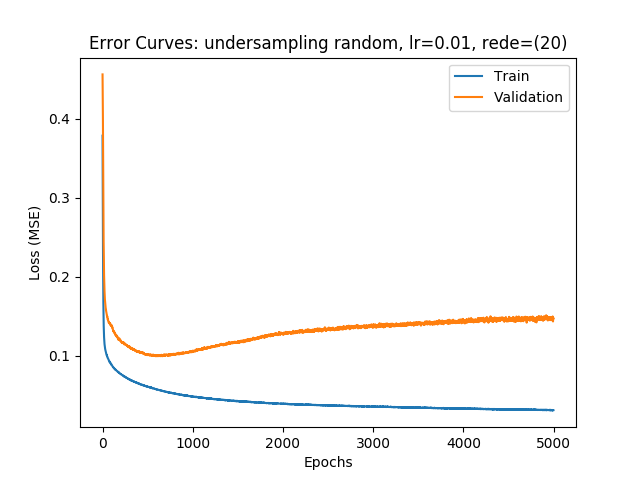

<IPython.core.display.Javascript object>


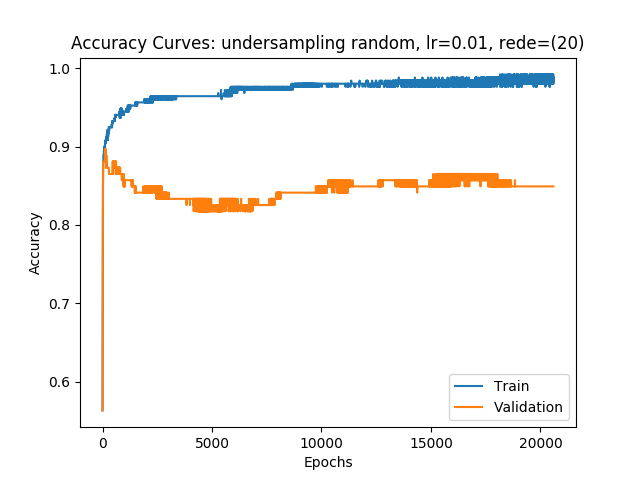

Matriz de confusão
[[1700  198]
 [  10   54]]

Train Loss:       0.0578
Validation Loss:  0.0994
Accuracy:         0.8940
MSE:              0.1060
AUROC:            0.8929


In [26]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [32]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.6919 - acc: 0.3849 - val_loss: 0.5612 - val_acc: 0.3651
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4474 - acc: 0.4127 - val_loss: 0.3986 - val_acc: 0.3968
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3255 - acc: 0.4683 - val_loss: 0.3153 - val_acc: 0.4683
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.2630 - acc: 0.5278 - val_loss: 0.2659 - val_acc: 0.5238
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.2263 - acc: 0.6190 - val_loss: 0.2388 - val_acc: 0.5714
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.2043 - acc: 0.6865 - val_loss: 0.2208 - val_acc: 0.6587
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.1891 - acc: 0.7262 - val_loss: 0.2092 - val_acc: 0.7063
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1309 - val_acc: 0.8175
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.0994 - acc: 0.8889 - val_loss: 0.1305 - val_acc: 0.8175
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8929 - val_loss: 0.1299 - val_acc: 0.8175
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8968 - val_loss: 0.1293 - val_acc: 0.8254
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8254
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8929 - val_loss: 0.1283 - val_acc: 0.8254
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8968 - val_loss: 0.1278 - val_acc: 0.8254
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8968 - val_loss: 0.1273 - val_acc:

252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1104 - val_acc: 0.8571
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9087 - val_loss: 0.1102 - val_acc: 0.8571
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8571
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9087 - val_loss: 0.1100 - val_acc: 0.8571
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8571
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9087 - val_loss: 0.1097 - val_acc: 0.8571
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9087 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9167 - val_loss: 0.1094 - v

252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9206 - val_loss: 0.1051 - val_acc: 0.8730
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9206 - val_loss: 0.1050 - val_acc: 0.8730
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9286 - val_loss: 0.1050 - val_acc: 0.8730
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9286 - val_loss: 0.1049 - val_acc: 0.8730
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9286 - val_loss: 0.1048 - val_acc: 0.8730
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9286 - val_loss: 0.1048 - val_acc: 0.8651
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9246 - val_loss: 0.1047 - val_acc: 0.8651
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9246 - val_loss: 0.1046 - v

252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9325 - val_loss: 0.1025 - val_acc: 0.8651
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9286 - val_loss: 0.1025 - val_acc: 0.8651
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9325 - val_loss: 0.1025 - val_acc: 0.8651
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9246 - val_loss: 0.1026 - val_acc: 0.8651
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9325 - val_loss: 0.1026 - val_acc: 0.8651
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9286 - val_loss: 0.1025 - val_acc: 0.8651
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9325 - val_loss: 0.1025 - val_acc: 0.8651
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9325 - val_loss: 0.1026 - v

252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1023 - val_acc: 0.8730
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1023 - val_acc: 0.8730
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9246 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9246 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9246 - val_loss: 0.1022 - v

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

<IPython.core.display.Javascript object>


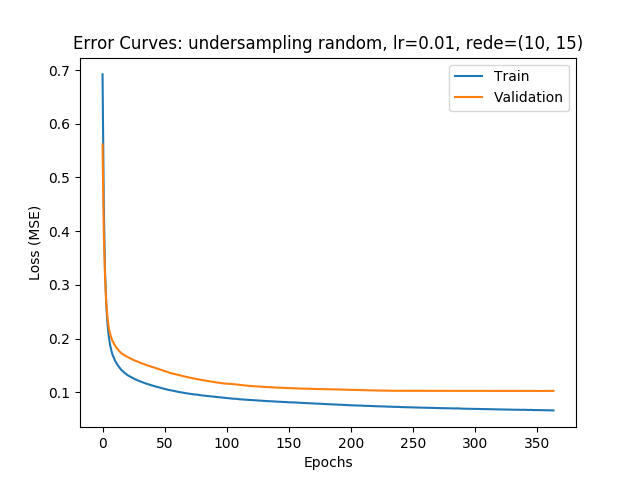

<IPython.core.display.Javascript object>


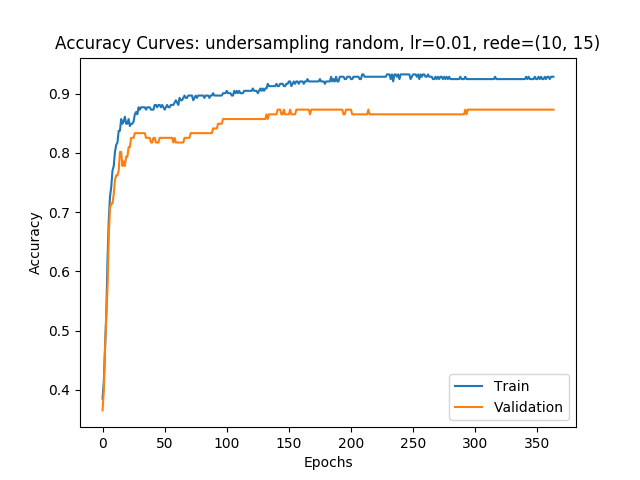

Matriz de confusão
[[1757  141]
 [  10   54]]

Train Loss:       0.0684
Validation Loss:  0.1022
Accuracy:         0.9230
MSE:              0.0770
AUROC:            0.9334


In [33]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history, graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [27]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

In [28]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.06849823699965997, 0.91182466858388456]


<IPython.core.display.Javascript object>


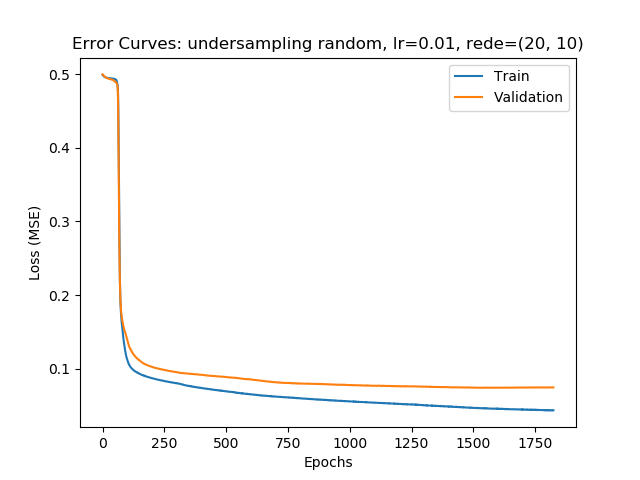

<IPython.core.display.Javascript object>


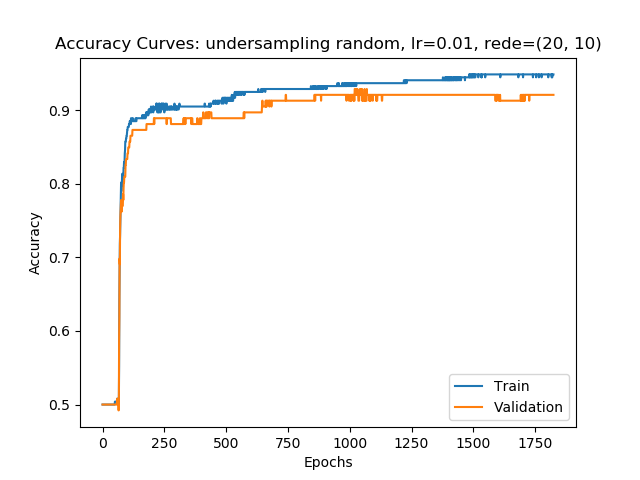

Matriz de confusão
[[1732  166]
 [   7   57]]

Train Loss:       0.0462
Validation Loss:  0.0739
Accuracy:         0.9118
MSE:              0.0882
AUROC:            0.9436


In [29]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, "(2)")
plot_training_acc_curves(history, "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, "(4)")
plot_training_acc_curves(history, "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))